In [1]:
## reset specific variables (replace regular_expression by the variables of interest)
#%reset_selective <regular_expression>

# reset all variables
%reset -f

In [76]:
## Importing libraries

from datetime import datetime, date, timedelta
from IPython.display import display, clear_output
import time
from array import *
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib
from pylab import savefig
import seaborn as sns
import pandas as pd
import csv
import json
import math
import datetime as dt
import pymongo as pym
from mongoengine import *
import statsmodels
%matplotlib inline



In [4]:
## Creating/Connecting Mongo DB instances

# Provide the mongodb atlas url to connect python to mongodb using pymongo
#CONNECTION_STRING = "mongodb+srv://<jgu>:<123>@<cluster-jgu>.mongodb.net/SMARTAttributesFilter"

connect(db='SMARTAttributesFilter', alias='SMARTAttributesFilter_alias')

connect(db='SMARTAttributesFilterOverWear', alias='SMARTAttributesFilterOverWear_alias')

connect(db='OverTimeSSDsFailures', alias='OverTimeSSDsFailures_alias')

connect(db='AllAppsSSDsFailures', alias='AllAppsSSDsFailures_alias')

connect(db='AllAppsSSDsLocation', alias='AllAppsSSDsLocation_alias')

connect(db='AllDiskIDSMARTAttributes', alias='AllDiskIDSMARTAttributes_alias')

connect(db='AllDiskIDSMARTAttributesFirstDay', alias='AllDiskIDSMARTAttributesFirstDay_alias')

connect(db='FailuresAppsLocation', alias='FailuresAppsLocation_alias')

connect(db='SMARTAtt_FailuresAppsLocation', alias='SMARTAtt_FailuresAppsLocation_alias')

MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True, read_preference=Primary(), uuidrepresentation=3)

In [5]:
## Setting document schema

# SMART attributes and disk information from the 2 years daily sampling dataset (500k disks)
class SMARTAtt(Document):
     disk_id = FloatField(required=False, default='0')
     timestamp = DateTimeField(required=False, default='0')
     model_x = StringField(required=False, default='0')
     r_sectors = FloatField(required=False, default='0')
     u_errors = FloatField(required=False, default='0')
     p_failedA = FloatField(required=False, default='0')
     p_failedB = FloatField(required=False, default='0')
     e_failedA = FloatField(required=False, default='0')
     e_failedB = FloatField(required=False, default='0')
     n_b_written = FloatField(required=False, default='0')
     n_b_read = FloatField(required=False, default='0')
     meta = {'db_alias': 'SMARTAttributesFilter_alias'}

# SMART attributes (related to wear) and disk information from the 2 years daily sampling dataset (500k disks)
class SMARTAttOverWear(Document):
     disk_id = FloatField(required=False, default='0')
     timestamp = DateTimeField(required=False, default='0')
     model_x = StringField(required=False, default='0')
     r_sectors = FloatField(required=False, default='0')
     w_l_count = FloatField(required=False, default='0')
     w_r_d = FloatField(required=False, default='0')
     media_wearout_i = FloatField(required=False, default='0')
     meta = {'db_alias': 'SMARTAttributesFilterOverWear_alias'}


# Failure time and disk information from the 2 years daily sampling dataset (500k disks)
class OverTimeSSDsFailures(Document):
     disk_id = FloatField(required=False, default='0')
     failure_time = DateTimeField(required=False, default='0')
     model_x = StringField(required=False, default='0')
     meta = {'db_alias': 'OverTimeSSDsFailures_alias'}

# Failure time and disk information (without model) from the full datset (1M disks)
class AllAppsSSDsFailures(Document):
     disk_id = FloatField(required=False, default='0')
     failure_time = DateTimeField(required=False, default='0')
     app = StringField(required=False, default='0')
     node_id = FloatField(required=False, default='0')
     rack_id = FloatField(required=False, default='0')
     machine_room_id = FloatField(required=False, default='0')
     meta = {'db_alias': 'AllAppsSSDsFailures_alias'}

# Apps and disks characteristics from the full dataset (1M disks)
class AllAppsSSDsLocation(Document):
     disk_id = FloatField(required=False, default='0')
     model_y = StringField(required=False, default='0')
     app = StringField(required=False, default='0')
     node_id = FloatField(required=False, default='0')
     rack_id = FloatField(required=False, default='0')
     slot_id = FloatField(required=False, default='0')
     meta = {'db_alias': 'AllAppsSSDsLocation_alias'}

# SMART attributes from the full dataset (1M disks)
class AllDiskIDSMARTAttributes(Document):
     disk_id = FloatField(required=False, default='0')
     model_y = StringField(required=False, default='0')
     r_sectors = FloatField(required=False, default='0')
     u_errors = FloatField(required=False, default='0')
     p_on = FloatField(required=False, default='0')
     p_c_count = FloatField(required=False, default='0')
     p_failedA = FloatField(required=False, default='0')
     p_failedB = FloatField(required=False, default='0')
     e_failedA = FloatField(required=False, default='0')
     e_failedB = FloatField(required=False, default='0')
     n_b_written = FloatField(required=False, default='0')
     n_b_read = FloatField(required=False, default='0')
     w_l_count = FloatField(required=False, default='0')
     w_r_d = FloatField(required=False, default='0')
     media_wearout_i = FloatField(required=False, default='0')
     meta = {'db_alias': 'AllDiskIDSMARTAttributes_alias'}

# First Day SMART attributes from the full dataset (1M disks)
class AllDiskIDSMARTAttributesFirstDay(Document):
     disk_id = FloatField(required=False, default='0')
     model_y = StringField(required=False, default='0')
     r_sectors = FloatField(required=False, default='0')
     u_errors = FloatField(required=False, default='0')
     p_on = FloatField(required=False, default='0')
     p_c_count = FloatField(required=False, default='0')
     p_failedA = FloatField(required=False, default='0')
     p_failedB = FloatField(required=False, default='0')
     e_failedA = FloatField(required=False, default='0')
     e_failedB = FloatField(required=False, default='0')
     n_b_written = FloatField(required=False, default='0')
     n_b_read = FloatField(required=False, default='0')
     w_l_count = FloatField(required=False, default='0')
     w_r_d = FloatField(required=False, default='0')
     media_wearout_i = FloatField(required=False, default='0')
     meta = {'db_alias': 'AllDiskIDSMARTAttributesFirstDay_alias'}

# Merge of OverTimeSSDsFailures and AllAppsSSDsFailures documents
class FailuresAppsLocation(Document):
     disk_id = FloatField(required=False, default='0')
     failure_time = DateTimeField(required=False, default='0')
     model_x = StringField(required=False, default='0')
     model_y = StringField(required=False, default='0')
     app = StringField(required=False, default='0')
     node_id = FloatField(required=False, default='0')
     rack_id = FloatField(required=False, default='0')
     machine_room_id = FloatField(required=False, default='0')
     meta = {'db_alias': 'FailuresAppsLocation_alias'}

class SMARTAtt_FailuresAppsLocation(Document):
     smart_att = ReferenceField(SMARTAtt)
     failures_app_location = ReferenceField(FailuresAppsLocation)
     meta = {'db_alias': 'SMARTAtt_FailuresAppsLocation_alias'}

In [ ]:
# Closing the connection to the DB

#disconnect(alias='SMARTAttributesFilter_alias')

#disconnect(alias='SMARTAttributesFilterOverWear_alias')

#disconnect(alias='OverTimeSSDsFailures_alias')

#disconnect(alias='AllAppsSSDsFailures_alias')

#disconnect(alias='AllAppsSSDsLocation_alias')

#disconnect(alias='AllDiskIDSMARTAttributes_alias')

#disconnect(alias='FailuresAppsLocation_alias')

#disconnect(alias='SMARTAtt_FailuresAppsLocation_alias')

In [108]:
myclient = pym.MongoClient("mongodb://localhost:27017/")
mydb = myclient["SMARTAttributesFilterOverWear"]
mycol = mydb["s_m_a_r_t_att_over_wear"]

myquery = { "model_x": { "$eq": "MB2" }}
myfields = {"disk_id":1, "r_sectors":1, "w_r_d":1, "_id":0}

mydoc = mycol.find(myquery, myfields)

In [109]:
list1 = list(mydoc)
df =  pd.DataFrame(list1)

In [113]:
df["model_y"] = "B2"

In [114]:
result = pd.merge(df, df_AlibabaSnapShot_AllAppsSSDsLocation[['disk_id', 'model_y', 'app']], on=['disk_id', 'model_y'], how='inner')

In [118]:
len(result)

348293

In [117]:
result.drop(result[result.r_sectors < 10].index, inplace=True)
#result.drop(result[result.w_r_d > 1500].index, inplace=True)


In [119]:
result.head()

,disk_id,r_sectors,w_r_d,model_y,app
0,19207.0,NaN,NaN,B2,none
1,19207.0,NaN,NaN,B2,none
384,23093.0,NaN,NaN,B2,RM
385,23093.0,NaN,NaN,B2,RM
849,2484.0,NaN,NaN,B2,RM


/tmp/ipykernel_27893/3579327804.py:5: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('/root/analysisJul29/B2Model/B21.pdf', dpi=300)
/tmp/ipykernel_27893/3579327804.py:5: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('/root/analysisJul29/B2Model/B21.pdf', dpi=300)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


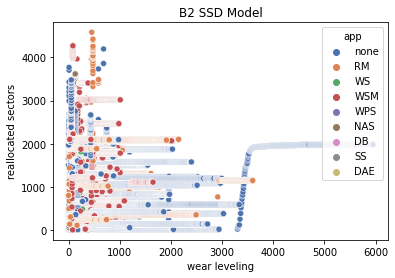

In [178]:
graph = sns.scatterplot(x = "w_r_d", y = 'r_sectors', palette = 'deep', hue='app', hue_order=['none','RM','WS','WSM', 'WPS', 'NAS', 'DB', 'SS', 'DAE'], data = result, markers=["o", "x", "+", "D", "v", "1", "s"])

graph.set(xlabel ="wear leveling", ylabel = "reallocated sectors", title ='B2 SSD Model')

plt.savefig('/root/analysisJul29/B2Model/B21.pdf', dpi=300)

/tmp/ipykernel_27893/1521556325.py:5: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('/root/analysisJul29/B2Model/B22.pdf', dpi=300)
/tmp/ipykernel_27893/1521556325.py:5: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('/root/analysisJul29/B2Model/B22.pdf', dpi=300)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


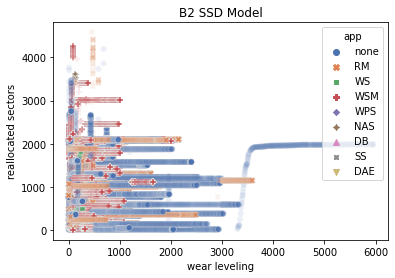

In [179]:
graph = sns.scatterplot(x = "w_r_d", y = 'r_sectors', palette = 'deep', hue='app', hue_order=['none','RM','WS','WSM', 'WPS', 'NAS', 'DB', 'SS', 'DAE'], data = result, style="app", alpha=0.1)

graph.set(xlabel ="wear leveling", ylabel = "reallocated sectors", title ='B2 SSD Model')

plt.savefig('/root/analysisJul29/B2Model/B22.pdf', dpi=300)

/tmp/ipykernel_27893/2588329198.py:5: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('/root/analysisJul29/B2Model/B23.pdf', dpi=300)
/tmp/ipykernel_27893/2588329198.py:5: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('/root/analysisJul29/B2Model/B23.pdf', dpi=300)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


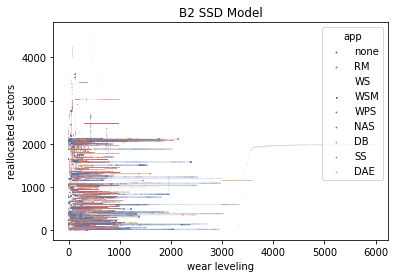

In [180]:
graph = sns.scatterplot(x = "w_r_d", y = 'r_sectors', size="app", sizes=(1, 1), palette = 'deep', hue='app', hue_order=['none','RM','WS','WSM', 'WPS', 'NAS', 'DB', 'SS', 'DAE'],data = result, style="app", alpha=0.1)

graph.set(xlabel ="wear leveling", ylabel = "reallocated sectors", title ='B2 SSD Model')

plt.savefig('/root/analysisJul29/B2Model/B23.pdf', dpi=300)

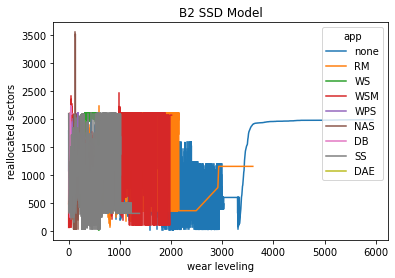

In [181]:
graph = sns.lineplot(data=result, x="w_r_d", y="r_sectors", hue="app",hue_order=['none','RM','WS','WSM', 'WPS', 'NAS', 'DB', 'SS', 'DAE'], estimator=np.mean, ci=90, markers=True, err_style="bars")
graph.set(xlabel ="wear leveling", ylabel = "reallocated sectors", title ='B2 SSD Model')
plt.savefig('/root/analysisJul29/B2Model/B24.pdf', dpi=300)

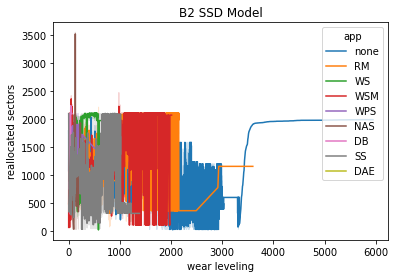

In [183]:
graph = sns.lineplot(data=result, x="w_r_d", y="r_sectors", hue="app", hue_order=['none','RM','WS','WSM', 'WPS', 'NAS', 'DB', 'SS', 'DAE'],estimator=np.mean, ci=90, markers=["o", "x", "+", "D", "v", "1", "s"])
graph.set(xlabel ="wear leveling", ylabel = "reallocated sectors", title ='B2 SSD Model')
plt.savefig('/root/analysisJul29/B2Model/B25.pdf', dpi=300)

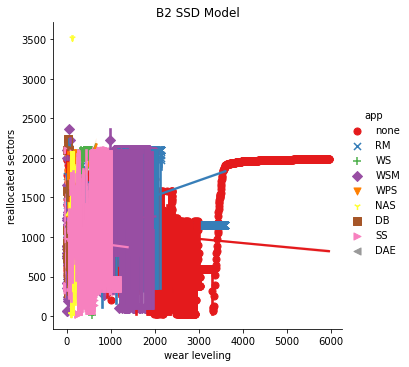

In [184]:
graph = sns.lmplot(x="w_r_d", y="r_sectors", hue="app", hue_order=['none','RM','WS','WSM', 'WPS', 'NAS', 'DB', 'SS', 'DAE'],data=result, markers=["o", "x", "+", "D", "v", "1", "s", ">", "<"], palette="Set1", x_estimator=np.mean, x_ci="ci", ci=60, fit_reg=True)
graph.set(xlabel ="wear leveling", ylabel = "reallocated sectors", title ='B2 SSD Model')
plt.savefig('/root/analysisJul29/B2Model/B26.pdf', dpi=300)

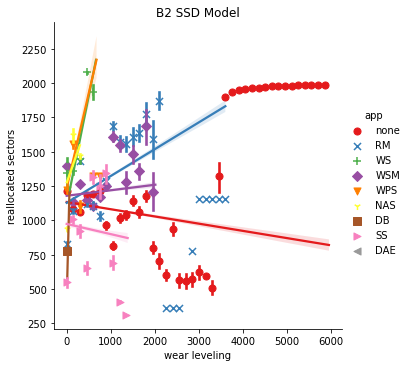

In [185]:
bin=np.arange(0,6000,150) #[150,300,450,600,750,900,1050,1200,1350]
graph = sns.lmplot(x="w_r_d", y="r_sectors", hue="app", hue_order=['none','RM','WS','WSM', 'WPS', 'NAS', 'DB', 'SS', 'DAE'],data=result, palette="Set1", markers=["o", "x", "+", "D", "v", "1", "s", ">", "<"], x_estimator=np.mean, x_ci="ci", ci=90, fit_reg=True, x_bins=bin, truncate=True, scatter=True)
graph.set(xlabel ="wear leveling", ylabel = "reallocated sectors", title ='B2 SSD Model')
plt.savefig('/root/analysisJul29/B2Model/B27.pdf', dpi=300)

/usr/local/lib/python3.9/dist-packages/seaborn/regression.py:301: RuntimeWarning: divide by zero encountered in log
  grid = np.c_[np.ones(len(grid)), np.log(grid)]
/usr/local/lib/python3.9/dist-packages/seaborn/regression.py:304: RuntimeWarning: divide by zero encountered in log
  _x = np.c_[_x[:, 0], np.log(_x[:, 1])]
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


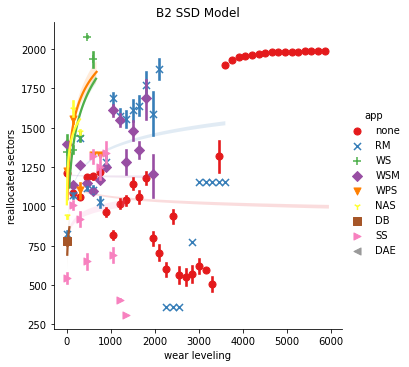

In [186]:
bin=np.arange(0,6000,150)
graph = sns.lmplot(x="w_r_d", y="r_sectors", hue="app", hue_order=['none','RM','WS','WSM', 'WPS', 'NAS', 'DB', 'SS', 'DAE'],data=result, palette="Set1", markers=["o", "x", "+", "D", "v", "1", "s", ">", "<"], x_estimator=np.mean, x_ci="ci", ci=90, fit_reg=True, x_bins=bin, truncate=True, scatter=True, logx=True)
graph.set(xlabel ="wear leveling", ylabel = "reallocated sectors", title ='B2 SSD Model')
plt.savefig('/root/analysisJul29/B2Model/B28.pdf', dpi=300)

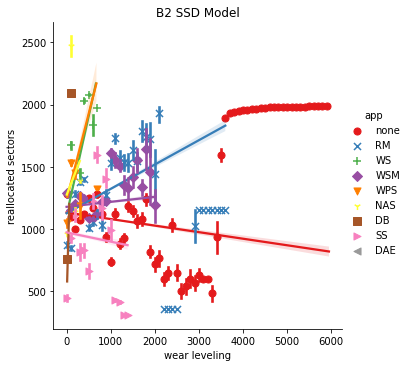

In [187]:
bin=np.arange(0,6000,100)
graph = sns.lmplot(x="w_r_d", y="r_sectors", hue="app", hue_order=['none','RM','WS','WSM', 'WPS', 'NAS', 'DB', 'SS', 'DAE'],data=result, palette="Set1", markers=["o", "x", "+", "D", "v", "1", "s", ">", "<"], x_estimator=np.mean, x_ci="ci", ci=90, fit_reg=True, x_bins=bin, truncate=True)
graph.set(xlabel ="wear leveling", ylabel = "reallocated sectors", title ='B2 SSD Model')
plt.savefig('/root/analysisJul29/B2Model/B29.pdf', dpi=300)

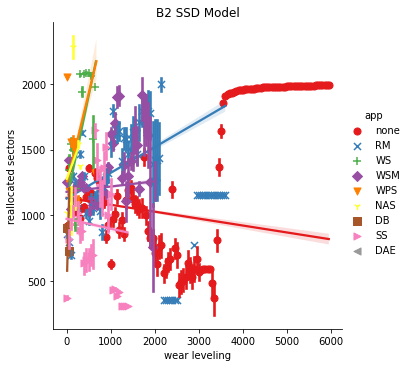

In [188]:
bin=np.arange(0,6000,50)
graph = sns.lmplot(x="w_r_d", y="r_sectors", hue="app", hue_order=['none','RM','WS','WSM', 'WPS', 'NAS', 'DB', 'SS', 'DAE'],data=result, palette="Set1", markers=["o", "x", "+", "D", "v", "1", "s", ">", "<"], x_estimator=np.mean, x_ci="ci", ci=90, fit_reg=True, x_bins=bin, truncate=True)
graph.set(xlabel ="wear leveling", ylabel = "reallocated sectors", title ='B2 SSD Model')
plt.savefig('/root/analysisJul29/B2Model/B210.pdf', dpi=300)

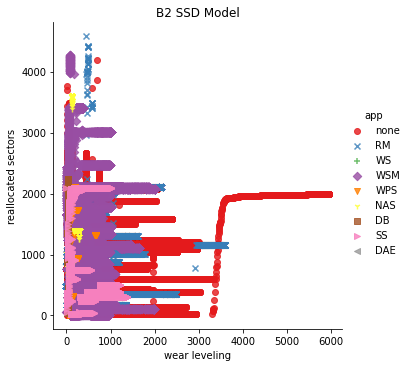

In [189]:
bin=np.arange(0,6000,25)    
graph = sns.lmplot(x="w_r_d", y="r_sectors", hue="app", hue_order=['none','RM','WS','WSM', 'WPS', 'NAS', 'DB', 'SS', 'DAE'],data=result, palette="Set1", markers=["o", "x", "+", "D", "v", "1", "s", ">", "<"], x_ci="ci", ci=None, fit_reg=False, truncate=True, scatter=True)
graph.set(xlabel ="wear leveling", ylabel = "reallocated sectors", title ='B2 SSD Model')
plt.savefig('/root/analysisJul29/B2Model/B211.pdf', dpi=300)

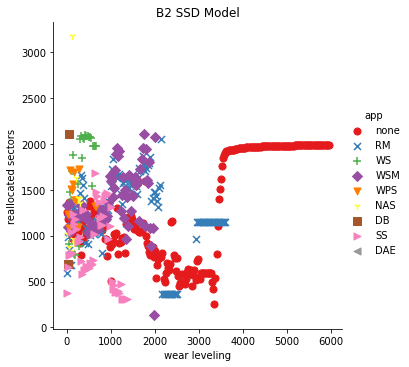

In [190]:
bin=np.arange(0,6000,25)
graph = sns.lmplot(x="w_r_d", y="r_sectors", hue="app", hue_order=['none','RM','WS','WSM', 'WPS', 'NAS', 'DB', 'SS', 'DAE'],data=result, palette="Set1", markers=["o", "x", "+", "D", "v", "1", "s", ">", "<"], x_estimator=np.mean, x_ci="ci", x_bins=bin, ci=None, fit_reg=False, truncate=True, scatter=True)
graph.set(xlabel ="wear leveling", ylabel = "reallocated sectors", title ='B2 SSD Model')
plt.savefig('/root/analysisJul29/B2Model/B212.pdf', dpi=300)

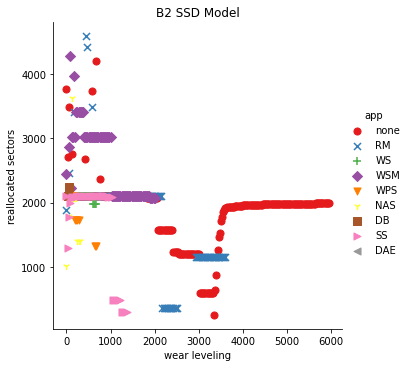

In [191]:
bin=np.arange(0,6000,25)
graph = sns.lmplot(x="w_r_d", y="r_sectors", hue="app", hue_order=['none','RM','WS','WSM', 'WPS', 'NAS', 'DB', 'SS', 'DAE'],data=result, palette="Set1", markers=["o", "x", "+", "D", "v", "1", "s", ">", "<"], x_estimator=np.max, x_ci="ci", x_bins=bin, ci=None, fit_reg=False, truncate=True, scatter=True)
graph.set(xlabel ="wear leveling", ylabel = "reallocated sectors", title ='B2 SSD Model')
plt.savefig('/root/analysisJul29/B2Model/B213.pdf', dpi=300)

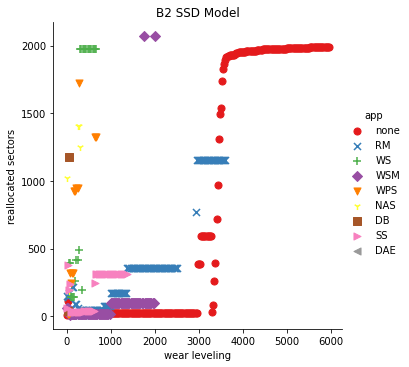

In [192]:
bin=np.arange(0,6000,25)
graph = sns.lmplot(x="w_r_d", y="r_sectors", hue="app",hue_order=['none','RM','WS','WSM', 'WPS', 'NAS', 'DB', 'SS', 'DAE'], data=result, palette="Set1", markers=["o", "x", "+", "D", "v", "1", "s", ">", "<"], x_estimator=min, x_ci="ci", x_bins=bin, ci=None, fit_reg=False, truncate=True, scatter=True)
graph.set(xlabel ="wear leveling", ylabel = "reallocated sectors", title ='B2 SSD Model')
plt.savefig('/root/analysisJul29/B2Model/B214.pdf', dpi=300)

In [ ]:
SMARTAttributesTestList = json.loads(SMARTAttributesTest.to_json())

SMARTAttributesTestDF = pd.DataFrame.from_dict(SMARTAttributesTestList)

# Modifying the mongo db date type to some human-readable type
dicDateToString = json.dumps(list(SMARTAttributesTestDF['timestamp']))
dicStringToJson = json.loads(dicDateToString)
dicJsonToDf = pd.DataFrame.from_dict(dicStringToJson)
SMARTAttributesTestDF['timestamp'] = dicJsonToDf['$date']

In [44]:
## Converting failure time columns to hours (for All failed SSDs dataset)

#Subctracting by the initial time of the experiment and turning into hours
SMARTAttributesTestDF['timestamp'] = SMARTAttributesTestDF.timestamp.sub(1514764800000)
SMARTAttributesTestDF['timestamp'] = SMARTAttributesTestDF.timestamp.div(1000)
SMARTAttributesTestDF['timestamp'] = SMARTAttributesTestDF.timestamp.div(60)
SMARTAttributesTestDF['timestamp'] = SMARTAttributesTestDF.timestamp.div(60)

In [45]:
SMARTAttributesTestDF.head()

,_id,disk_id,timestamp,model_x,r_sectors,w_l_count,w_r_d,media_wearout_i
0,{'$oid': '62bf1f3ccf36687e85506fc4'},10001.0,0.0,MA1,NaN,NaN,NaN,NaN
1,{'$oid': '62bf1f3ccf36687e85506fcb'},10018.0,0.0,MA1,NaN,NaN,NaN,NaN
2,{'$oid': '62bf1f3ccf36687e85506fd9'},10044.0,0.0,MA1,NaN,NaN,NaN,NaN
3,{'$oid': '62bf1f3ccf36687e85506feb'},10063.0,0.0,MA1,NaN,NaN,NaN,NaN
4,{'$oid': '62bf1f3ccf36687e85507009'},10100.0,0.0,MA1,NaN,NaN,NaN,NaN


In [ ]:
### Some queries pandas

## Find an specific line based on a specific value from a column
#df_failuresLocationDocumentsJsonMTTF.loc[df_failuresLocationDocumentsJsonMTTF["mtff_node"] == 2] 
#d1 = data[data["City"] == "Houston"]
#dataFrame.Reg_Price[i]

## Ploting very basic graphs
#df.groupby('Sex').sum().plot(kind='bar');
#print(df_app)
#df_appNode.groupby(['app']).plot(kind='bar')
#df.groupby(['Sex', 'Survived'] )['Survived'].count().plot.bar(figsize=(8, 6));

In [ ]:
# Querying/Reading the OverTimeSSDsFailures database (mongodb) and turning It into a pandas dataframe

doc_AlibabaOver_Failurelogs = OverTimeSSDsFailures.objects()

jSon_AlibabaOver_Failurelogs = json.loads(doc_AlibabaOver_Failurelogs.to_json())
df_AlibabaOver_Failurelogs = pd.DataFrame.from_dict(jSon_AlibabaOver_Failurelogs) 

# Modifying the mongo db date type to some human-readable type
dicDateToString = json.dumps(list(df_AlibabaOver_Failurelogs['failure_time']))
dicStringToJson = json.loads(dicDateToString)
dicJsonToDf = pd.DataFrame.from_dict(dicStringToJson)
df_AlibabaOver_Failurelogs['failure_time'] = dicJsonToDf['$date']

In [ ]:
# Querying/Reading the AllAppsSSDsFailures database (mongodb) and turning It into a pandas dataframe

doc_AlibabaSnapShot_FailuresAppsLocation = AllAppsSSDsFailures.objects()

jSon_AlibabaSnapShot_FailuresAppsLocation = json.loads(doc_AlibabaSnapShot_FailuresAppsLocation.to_json())
df_AlibabaSnapShot_FailuresAppsLocation = pd.DataFrame.from_dict(jSon_AlibabaSnapShot_FailuresAppsLocation) 

# Modifying the mongo db date type to some human-readable type
dicDateToString = json.dumps(list(df_AlibabaSnapShot_FailuresAppsLocation['failure_time']))
dicStringToJson = json.loads(dicDateToString)
dicJsonToDf = pd.DataFrame.from_dict(dicStringToJson)
df_AlibabaSnapShot_FailuresAppsLocation['failure_time'] = dicJsonToDf['$date']

In [6]:
# Querying/Reading the AllAppsSSDsLocation database (mongodb)

doc_AlibabaSnapShot_AllAppsSSDsLocation = AllAppsSSDsLocation.objects()

jSon_AlibabaSnapShot_AllAppsSSDsLocation = json.loads(doc_AlibabaSnapShot_AllAppsSSDsLocation.to_json())
df_AlibabaSnapShot_AllAppsSSDsLocation = pd.DataFrame.from_dict(jSon_AlibabaSnapShot_AllAppsSSDsLocation) 

In [21]:
# Querying/Reading the AllDiskIDSMARTAttributes database (mongodb)

doc_AlibabaSnapShot_AllDiskIDSMARTAttributes = AllDiskIDSMARTAttributes.objects()

jSon_AlibabaSnapShot_AllDiskIDSMARTAttributes = json.loads(doc_AlibabaSnapShot_AllDiskIDSMARTAttributes.to_json())
df_AlibabaSnapShot_AllDiskIDSMARTAttributes = pd.DataFrame.from_dict(jSon_AlibabaSnapShot_AllDiskIDSMARTAttributes) 

In [22]:
# Querying/Reading the AllDiskIDSMARTAttributesFirstDay database (mongodb)

doc_AlibabaSnapShot_AllDiskIDSMARTAttributesFirstDay = AllDiskIDSMARTAttributesFirstDay.objects()

jSon_AlibabaSnapShot_AllDiskIDSMARTAttributesFirstDay = json.loads(doc_AlibabaSnapShot_AllDiskIDSMARTAttributesFirstDay.to_json())
df_AlibabaSnapShot_AllDiskIDSMARTAttributesFirstDay = pd.DataFrame.from_dict(jSon_AlibabaSnapShot_AllDiskIDSMARTAttributesFirstDay) 

In [8]:
# Querying/Reading the FailuresAppsLocation database (mongodb) and turning It into a pandas dataframe - DB which merges both failures dataset

doc_MergeDs_FailuresAppsLocation = FailuresAppsLocation.objects()

jSon_MergeDs_FailuresAppsLocation = json.loads(doc_MergeDs_FailuresAppsLocation.to_json())
df_MergeDs_FailuresAppsLocation = pd.DataFrame.from_dict(jSon_MergeDs_FailuresAppsLocation) 

# Modifying the mongo db date type to some human-readable type
dicDateToString = json.dumps(list(df_MergeDs_FailuresAppsLocation['failure_time']))
dicStringToJson = json.loads(dicDateToString)
dicJsonToDf = pd.DataFrame.from_dict(dicStringToJson)
df_MergeDs_FailuresAppsLocation['failure_time'] = dicJsonToDf['$date']

In [9]:
## Converting failure time columns to hours (for SSDs in common dataset)

# creating a temporary variable to be used to calculate the general mttf equation approach
df_genMTTF_MergeDs_FailuresAppsLocation = df_MergeDs_FailuresAppsLocation

## Value representing: 2018-01-01 00:00:00 (starting date from the experiment)
#1514764800000

#Subctracting by the initial time of the experiment and turning into hours
df_genMTTF_MergeDs_FailuresAppsLocation['failure_time'] = df_MergeDs_FailuresAppsLocation.failure_time.sub(1514764800000)
df_genMTTF_MergeDs_FailuresAppsLocation['failure_time'] = df_MergeDs_FailuresAppsLocation.failure_time.div(1000)
df_genMTTF_MergeDs_FailuresAppsLocation['failure_time'] = df_MergeDs_FailuresAppsLocation.failure_time.div(60)
df_genMTTF_MergeDs_FailuresAppsLocation['failure_time'] = df_MergeDs_FailuresAppsLocation.failure_time.div(60)
#df_failuresLocationDocumentsJsonMTTF.head(3)

In [10]:
## Converting failure time columns to hours (for All failed SSDs dataset)

#Subctracting by the initial time of the experiment and turning into hours
df_AlibabaSnapShot_FailuresAppsLocation['failure_time'] = df_AlibabaSnapShot_FailuresAppsLocation.failure_time.sub(1514764800000)
df_AlibabaSnapShot_FailuresAppsLocation['failure_time'] = df_AlibabaSnapShot_FailuresAppsLocation.failure_time.div(1000)
df_AlibabaSnapShot_FailuresAppsLocation['failure_time'] = df_AlibabaSnapShot_FailuresAppsLocation.failure_time.div(60)
df_AlibabaSnapShot_FailuresAppsLocation['failure_time'] = df_AlibabaSnapShot_FailuresAppsLocation.failure_time.div(60)
#df_AlibabaSnapShot_FailuresAppsLocation.head()

In [11]:
## Calculating MTTF (general equation) per node, rack and general using failed SSDs in common

# Unique values by column
id_apps = df_genMTTF_MergeDs_FailuresAppsLocation.app.unique()
#id_nodes = df_failuresLocationDocumentsJsonMTTF.node_id.unique()
#id_racks = nodes = df_failuresLocationDocumentsJsonMTTF.rack_id.unique()
#id_ssds = nodes = df_failuresLocationDocumentsJsonMTTF.disk_id.unique()

#Calculating the MTTFs
#df_general = df_failuresLocationDocumentsJsonMTTF['failure_time'].mean()
df_appNode = df_genMTTF_MergeDs_FailuresAppsLocation.groupby(['app', 'node_id'])['failure_time'].mean()
df_appNode = pd.DataFrame(df_appNode)
df_appNode.rename(columns = {'failure_time':'mttf_appNode'}, inplace=True)
df_appRack = df_genMTTF_MergeDs_FailuresAppsLocation.groupby(['app', 'rack_id'])['failure_time'].mean()
df_appRack = pd.DataFrame(df_appRack)
df_appRack.rename(columns = {'failure_time':'mttf_appRack'}, inplace=True)
df_app = df_genMTTF_MergeDs_FailuresAppsLocation.groupby(['app'])['failure_time'].mean()
df_app = pd.DataFrame(df_app)
df_app.rename(columns = {'failure_time':'mttf_app'}, inplace=True)
#df_all = df_failuresLocationDocumentsJsonMTTF.groupby(['app', 'rack_id', 'node_id'])['failure_time'].mean()

# Merging the results with the original dataframe
df_result = pd.merge(df_genMTTF_MergeDs_FailuresAppsLocation, df_appNode, how='left', on=['app', 'node_id'])
df_result = pd.merge(df_result, df_appRack, how='left', on=['app', 'rack_id'])
df_result = pd.merge(df_result, df_app, how='left', on=['app'])

# Selecting the columns of interest
df_resultFiltered = df_result.loc[:,['app','node_id', 'rack_id','mttf_appNode','mttf_appRack','mttf_app']]
#df_resultFiltered.to_csv('failuresLocationApp.csv')

In [55]:
df_result.head()

,_id,disk_id,failure_time,model_x,model_y,app,node_id,rack_id,machine_room_id,mttf_appNode,mttf_appRack,mttf_app
0,{'$oid': '6266c2e8718b63c8dff976fb'},33722.0,43.258889,MA2,A2,RM,66688.0,11488.0,455.0,43.258889,2731.489028,9314.031077
1,{'$oid': '6266c2e8718b63c8dff976fc'},58337.0,46.754444,MA2,A2,RM,114833.0,9859.0,455.0,46.754444,46.754444,9314.031077
2,{'$oid': '6266c2e8718b63c8dff976fd'},26378.0,51.395556,MA1,A3,none,145735.0,6860.0,127.0,4203.318264,4534.032191,9568.609801
3,{'$oid': '6266c2e8718b63c8dff976fe'},39876.0,51.490833,MA1,A3,RM,217964.0,17596.0,92.0,51.490833,2603.324954,9314.031077
4,{'$oid': '6266c2e8718b63c8dff976ff'},199348.0,53.050833,MC1,C1,NAS,237451.0,22765.0,137.0,53.050833,7399.522222,11613.122213


In [12]:
### To investigate the SSDs by application

exp_years = 2
exp_months = 12*exp_years
hours_per_year = 365*24
id_apps = df_AlibabaSnapShot_AllAppsSSDsLocation.app.unique()


#Creating a dataframe to generate some statistics taking into account the application which is running
df_idApps = pd.DataFrame(id_apps, columns=["app"])
#Adding empty colums
df_idAppsSSDs = pd.DataFrame(df_idApps, columns=["app", "N_AllSSDsApp", "N_failed_SDDs",  "AFR_SDDs", "mttf_SDDs", "AFR_SDDs_total", "mttf_SDDs_total", "N_failed_CommonSDDs",  "AFR_CommonSDDs", "mttf_CommonSDDs","AFR_CommonSDDs_total", "mttf_CommonSDDs_total"])


for i in id_apps:
    #Looping the AlibabaSnapshot_AllAppsSSDsLocation DB in order to count the total of ssds by application    
    df_idAppsSSDs.loc[(df_idAppsSSDs['app']) == i, 'N_AllSSDsApp'] = df_AlibabaSnapShot_AllAppsSSDsLocation.loc[(df_AlibabaSnapShot_AllAppsSSDsLocation['app']) == i]['disk_id'].count()
    
    #Looping the FailuresAppsLocation (merged dss) in order to count the number of failed ssds by application    
    df_idAppsSSDs.loc[(df_idAppsSSDs['app']) == i, 'N_failed_CommonSDDs'] = df_MergeDs_FailuresAppsLocation.loc[(df_MergeDs_FailuresAppsLocation['app']) == i]['disk_id'].count()
    #Looping the AllAppsSSDsFailures DB in order to count the number of failed ssds by application    
    df_idAppsSSDs.loc[(df_idAppsSSDs['app']) == i, 'N_failed_SDDs'] = df_AlibabaSnapShot_FailuresAppsLocation.loc[(df_AlibabaSnapShot_FailuresAppsLocation['app']) == i]['disk_id'].count()
    
    # Calculating specific (failedSSDsperApp/TotalSSDsperAPP) app AFR and MTTF using failed ssds from the Alibaba Snapshot database (AllAppsSSDsFailures)
    df_idAppsSSDs.loc[(df_idAppsSSDs['app']) == i, 'AFR_SDDs'] = ((df_idAppsSSDs.loc[(df_idAppsSSDs['app']) == i, 'N_failed_SDDs'])*(12/exp_months))/(df_idAppsSSDs.loc[(df_idAppsSSDs['app']) == i, 'N_AllSSDsApp'])
    df_idAppsSSDs.loc[(df_idAppsSSDs['app']) == i, 'mttf_SDDs'] = (hours_per_year)/(df_idAppsSSDs.loc[(df_idAppsSSDs['app']) == i, 'AFR_SDDs'])
    # Calculating specific (failedSSDsCommonperApp/TotalSSDsCommonperApp) app AFR and MTTF using failed ssds in common to the Snapshot and Overtime databases (FailuresAppsLocation)
    df_idAppsSSDs.loc[(df_idAppsSSDs['app']) == i, 'AFR_CommonSDDs'] = ((df_idAppsSSDs.loc[(df_idAppsSSDs['app']) == i, 'N_failed_CommonSDDs'])*(12/exp_months))/(df_idAppsSSDs.loc[(df_idAppsSSDs['app']) == i, 'N_AllSSDsApp'])
    df_idAppsSSDs.loc[(df_idAppsSSDs['app']) == i, 'mttf_CommonSDDs'] = (hours_per_year)/(df_idAppsSSDs.loc[(df_idAppsSSDs['app']) == i, 'AFR_CommonSDDs'])
    
for i in id_apps:
    # Calculating total (failedSSDsperApp/TotalSSDsExperiment) AFR and MTTF using failed ssds from the Alibaba Snapshot database (AllAppsSSDsFailures)
    df_idAppsSSDs.loc[(df_idAppsSSDs['app']) == i, 'AFR_SDDs_total'] = ((df_idAppsSSDs.loc[(df_idAppsSSDs['app']) == i, 'N_failed_SDDs'])*(12/exp_months))/(df_idAppsSSDs.N_AllSSDsApp.sum())
    df_idAppsSSDs.loc[(df_idAppsSSDs['app']) == i, 'mttf_SDDs_total'] = (hours_per_year)/(df_idAppsSSDs.loc[(df_idAppsSSDs['app']) == i, 'AFR_SDDs_total'])
    # Calculating total (failedSSDsCommonperApp/TotalSSDsExperiment) AFR and MTTF using failed ssds in common to the Snapshot and Overtime databases (FailuresAppsLocation)
    df_idAppsSSDs.loc[(df_idAppsSSDs['app']) == i, 'AFR_CommonSDDs_total'] = ((df_idAppsSSDs.loc[(df_idAppsSSDs['app']) == i, 'N_failed_CommonSDDs'])*(12/exp_months))/(df_idAppsSSDs.N_AllSSDsApp.sum())
    df_idAppsSSDs.loc[(df_idAppsSSDs['app']) == i, 'mttf_CommonSDDs_total'] = (hours_per_year)/(df_idAppsSSDs.loc[(df_idAppsSSDs['app']) == i, 'AFR_CommonSDDs_total'])

#Merging mttf per app to include the MTTF (this calculated using the general MTTF equation - not storage's specific) column into the failed ssds by application dataframe
df_idAppsSSDsMTTF = pd.merge(df_idAppsSSDs, df_app, how='left', on=['app'])
#df_idAppsSSDsMTTF.head(20)

df_idAppsSSDs.head(20)


,app,N_AllSSDsApp,N_failed_SDDs,AFR_SDDs,mttf_SDDs,AFR_SDDs_total,mttf_SDDs_total,N_failed_CommonSDDs,AFR_CommonSDDs,mttf_CommonSDDs,AFR_CommonSDDs_total,mttf_CommonSDDs_total
0,WPS,44676.0,529.0,0.005920,1.479629e+06,0.000274,3.197632e+07,496.0,0.005551,1.578072e+06,0.000257,3.410378e+07
1,WSM,380170.0,8916.0,0.011726,7.470366e+05,0.004617,1.897204e+06,8161.0,0.010733,8.161473e+05,0.004226,2.072721e+06
2,RM,183981.0,3016.0,0.008196,1.068749e+06,0.001562,5.608578e+06,2602.0,0.007071,1.238796e+06,0.001347,6.500950e+06
3,none,248757.0,3552.0,0.007139,1.226977e+06,0.001839,4.762239e+06,2966.0,0.005962,1.469394e+06,0.001536,5.703126e+06
4,WS,17740.0,232.0,0.006539,1.339676e+06,0.000120,7.291152e+07,61.0,0.001719,5.095161e+06,0.000032,2.773028e+08
5,DB,26781.0,203.0,0.003790,2.311345e+06,0.000105,8.332745e+07,113.0,0.002110,4.152240e+06,0.000059,1.496944e+08
6,DAE,16000.0,1214.0,0.037937,2.309061e+05,0.000629,1.393367e+07,1214.0,0.037937,2.309061e+05,0.000629,1.393367e+07
7,SS,32936.0,184.0,0.002793,3.136080e+06,0.000095,9.193192e+07,151.0,0.002292,3.821448e+06,0.000078,1.120230e+08
8,NAS,14454.0,541.0,0.018715,4.680852e+05,0.000280,3.126705e+07,541.0,0.018715,4.680852e+05,0.000280,3.126705e+07


In [13]:
### To investigate the SDDs without app distinguishing

#Creating a data frame to calculate the AFR and MTTF without app distinguishing.
data = {'FailedSSDsSet':['FailedSSDs', 'FailedCommonSSDs']}
df_general_AFRMTTF = pd.DataFrame(data)
df_general_AFRMTTF = pd.DataFrame(df_general_AFRMTTF, columns=['FailedSSDsSet', 'AFR_General', 'MTTF_General'])

# Calculating general (failedSSDs/TotalSSDsExperiment) AFR and MTTF using failed ssds from the Alibaba Snapshot database (AllAppsSSDsFailures)
df_general_AFRMTTF.loc[(df_general_AFRMTTF['FailedSSDsSet']) == 'FailedSSDs', 'AFR_General'] = ((df_idAppsSSDs.N_failed_SDDs.sum())*(12/exp_months))/(df_idAppsSSDs.N_AllSSDsApp.sum())
df_general_AFRMTTF.loc[(df_general_AFRMTTF['FailedSSDsSet']) == 'FailedSSDs', 'MTTF_General'] = (hours_per_year)/(df_general_AFRMTTF.loc[(df_general_AFRMTTF['FailedSSDsSet']) == 'FailedSSDs', 'AFR_General'])
# Calculating general AFR and MTTF using failed ssds in common to the Snapshot and Overtime databases (FailuresAppsLocation)
df_general_AFRMTTF.loc[(df_general_AFRMTTF['FailedSSDsSet']) == 'FailedCommonSSDs', 'AFR_General'] = ((df_idAppsSSDs.N_failed_CommonSDDs.sum())*(12/exp_months))/(df_idAppsSSDs.N_AllSSDsApp.sum())
df_general_AFRMTTF.loc[(df_general_AFRMTTF['FailedSSDsSet']) == 'FailedCommonSSDs', 'MTTF_General'] = (hours_per_year)/(df_general_AFRMTTF.loc[(df_general_AFRMTTF['FailedSSDsSet']) == 'FailedCommonSSDs', 'AFR_General'])
df_general_AFRMTTF.head()
#df_idAppsSSDs.N_AllSSDsApp.sum()

,FailedSSDsSet,AFR_General,MTTF_General
0,FailedSSDs,0.009522,9.199691e+05
1,FailedCommonSSDs,0.008444,1.037441e+06


In [309]:
### To investigate the AFR and MTTF per SSD models for each application

exp_years = 2
exp_months = 12*exp_years
hours_per_year = 365*24
id_apps = df_AlibabaSnapShot_AllAppsSSDsLocation.app.unique()
id_models = df_AlibabaSnapShot_AllAppsSSDsLocation.model_y.unique()

# merge because alibaba's failure dataset doesn't contains the ssds models
df_MergeAlibabaAllandFailures =  pd.merge(df_AlibabaSnapShot_AllAppsSSDsLocation, df_AlibabaSnapShot_FailuresAppsLocation, how = 'inner', on = ['app', 'disk_id', 'node_id'])

df_idModelsSSDs = pd.DataFrame(columns=["app", "models", "N_AllSSDsApp", "N_failed_SDDs",  "AFR_SDDs", "mttf_SDDs"])

for j in id_models:
    for i in id_apps:
    
        #Looping the AlibabaSnapshot_AllAppsSSDsLocation DB in order to count the total of ssds/model by application    
        numberTotalSSDs = df_AlibabaSnapShot_AllAppsSSDsLocation.loc[(df_AlibabaSnapShot_AllAppsSSDsLocation.app.isin([i]) & df_AlibabaSnapShot_AllAppsSSDsLocation.model_y.isin([j])), "disk_id"].count()
        
        numberFailedSSDs = df_MergeAlibabaAllandFailures.loc[(df_MergeAlibabaAllandFailures.app.isin([i]) & df_MergeAlibabaAllandFailures.model_y.isin([j])), "disk_id"].count()

        if numberFailedSSDs != 0:
            AFR_SSDs = ((numberFailedSSDs)*(12/exp_months))/(numberTotalSSDs)
            MTTF_SSDs = (hours_per_year)/(AFR_SSDs)
        else: 
            AFR_SSDs = 0
            MTTF_SSDs = 0
        df_temp = pd.DataFrame(columns=["app", "models", "N_AllSSDsApp", "N_failed_SDDs",  "AFR_SDDs", "mttf_SDDs"])
        df_temp.loc[-1] = {'app' : i , 'models' : j, 'N_AllSSDsApp' : numberTotalSSDs, 'N_failed_SDDs': numberFailedSSDs, 'AFR_SDDs': AFR_SSDs, 'mttf_SDDs': MTTF_SSDs}
        df_idModelsSSDs = pd.concat([df_idModelsSSDs, df_temp], ignore_index=True)


df_idModelsSSDs.head(90)

,app,models,N_AllSSDsApp,N_failed_SDDs,AFR_SDDs,mttf_SDDs
0,WPS,A1,9832,26,0.001322,6625255.384615
1,WSM,A1,112560,207,0.00092,9526817.391304
2,RM,A1,53156,187,0.001759,4980177.112299
3,none,A1,73750,173,0.001173,7468786.127168
4,WS,A1,10005,117,0.005847,1498184.615385
...,...,...,...,...,...,...
85,WS,A3,637,6,0.00471,1860040.0
86,DB,A3,1696,56,0.016509,530605.714286
87,DAE,A3,336,2,0.002976,2943360.0
88,SS,A3,2480,80,0.016129,543120.0


In [15]:
### To investigate the AFR and MTTF per SSD flash technology for each application

df_temp = df_idModelsSSDs.copy()
df_temp["tech"] = " "

df_temp.loc[(df_temp.models.isin(['A1']) | df_temp.models.isin(['A2']) | df_temp.models.isin(['A3']) | df_temp.models.isin(['A4']) | df_temp.models.isin(['A5']) | df_temp.models.isin(['A6']) | df_temp.models.isin(['B1']) | df_temp.models.isin(['B2']) | df_temp.models.isin(['B3'])), 'tech'] = 'MLC'
df_temp.loc[(df_temp.models.isin(['C1']) | df_temp.models.isin(['C2'])), 'tech'] = '3D-TLC'

df_temp1 = df_temp.groupby(['app', 'tech'], as_index=False)['N_failed_SDDs'].sum()
df_temp2 = df_temp.groupby(['app', 'tech'], as_index=False)['N_AllSSDsApp'].sum()
df_idTechSSDs = pd.merge(df_temp1, df_temp2, how='inner', on=['app', 'tech'])

df_idTechSSDs["AFR_SSDs"] = " "
df_idTechSSDs["mttf_SDDs"] = " "

for i in range(0, len(df_idTechSSDs)): 
    

    numberTotalSSDs = df_idTechSSDs.iloc[i].N_AllSSDsApp
    numberFailedSSDs = df_idTechSSDs.iloc[i].N_failed_SDDs
       
    if numberFailedSSDs != 0:
        AFR_SSDs = ((numberFailedSSDs)*(12/exp_months))/(numberTotalSSDs)
        MTTF_SSDs = (hours_per_year)/(AFR_SSDs)
    else: 
        AFR_SSDs = 0
        MTTF_SSDs = 0

    df_idTechSSDs.loc[i, 'AFR_SSDs'] = AFR_SSDs
    df_idTechSSDs.loc[i, 'mttf_SDDs'] = MTTF_SSDs

df_idTechSSDs.head(20)

,app,tech,N_failed_SDDs,N_AllSSDsApp,AFR_SSDs,mttf_SDDs
0,DAE,3D-TLC,1187,11196,0.05301,165251.828138
1,DAE,MLC,27,4804,0.00281,3117262.222222
2,DB,3D-TLC,15,868,0.008641,1013824.0
3,DB,MLC,188,25913,0.003628,2414871.06383
4,NAS,3D-TLC,526,12508,0.021027,416616.273764
5,NAS,MLC,15,1946,0.003854,2272928.0
6,RM,3D-TLC,998,15454,0.032289,271296.673347
7,RM,MLC,2018,168527,0.005987,1463128.364718
8,SS,3D-TLC,33,1298,0.012712,689120.0
9,SS,MLC,151,31638,0.002386,3670846.092715


In [16]:
### To investigate the AFR and MTTF per SSD capacity for each application

df_temp = df_idModelsSSDs.copy()
df_temp["capacity"] = " "

df_temp.loc[(df_temp.models.isin(['A1']) | df_temp.models.isin(['A3']) | df_temp.models.isin(['A5']) | df_temp.models.isin(['B1'])), 'capacity'] = '480GB'
df_temp.loc[(df_temp.models.isin(['B2']) | df_temp.models.isin(['B3']) | df_temp.models.isin(['C1'])), 'capacity'] = '1920GB'
df_temp.loc[(df_temp.models.isin(['A2']) | df_temp.models.isin(['A6'])), 'capacity'] = '800GB'
df_temp.loc[(df_temp.models.isin(['A4'])), 'capacity'] = '240GB'
df_temp.loc[(df_temp.models.isin(['C2'])), 'capacity'] = '960GB'

df_temp1 = df_temp.groupby(['app', 'capacity'], as_index=False)['N_failed_SDDs'].sum()
df_temp2 = df_temp.groupby(['app', 'capacity'], as_index=False)['N_AllSSDsApp'].sum()
df_idCapacitySSDs = pd.merge(df_temp1, df_temp2, how='inner', on=['app', 'capacity'])

df_idCapacitySSDs["AFR_SSDs"] = " "
df_idCapacitySSDs["mttf_SDDs"] = " "

for i in range(0, len(df_idCapacitySSDs)): 
    

    numberTotalSSDs = df_idCapacitySSDs.iloc[i].N_AllSSDsApp
    numberFailedSSDs = df_idCapacitySSDs.iloc[i].N_failed_SDDs
       
    if numberFailedSSDs != 0:
        AFR_SSDs = ((numberFailedSSDs)*(12/exp_months))/(numberTotalSSDs)
        MTTF_SSDs = (hours_per_year)/(AFR_SSDs)
    else: 
        AFR_SSDs = 0
        MTTF_SSDs = 0

    df_idCapacitySSDs.loc[i, 'AFR_SSDs'] = AFR_SSDs
    df_idCapacitySSDs.loc[i, 'mttf_SDDs'] = MTTF_SSDs

df_idCapacitySSDs.head(20)

,app,capacity,N_failed_SDDs,N_AllSSDsApp,AFR_SSDs,mttf_SDDs
0,DAE,1920GB,635,11689,0.027162,322505.952756
1,DAE,240GB,0,13,0,0
2,DAE,480GB,2,1879,0.000532,16460040.0
3,DAE,800GB,3,399,0.003759,2330160.0
4,DAE,960GB,574,2020,0.142079,61655.749129
5,DB,1920GB,51,3300,0.007727,1133647.058824
6,DB,240GB,1,78,0.00641,1366560.0
7,DB,480GB,89,17957,0.002478,3534906.067416
8,DB,800GB,62,5446,0.005692,1538934.193548
9,DB,960GB,0,0,0,0


In [17]:
### To investigate the AFR and MTTF per SSD lithography for each application

df_temp = df_idModelsSSDs.copy()
df_temp["lithography"] = " "

df_temp.loc[(df_temp.models.isin(['A1']) | df_temp.models.isin(['A2']) | df_temp.models.isin(['A3']) | df_temp.models.isin(['A6'])), 'lithography'] = '20nm'
df_temp.loc[(df_temp.models.isin(['A4']) | df_temp.models.isin(['A5'])), 'lithography'] = '16nm'
df_temp.loc[(df_temp.models.isin(['C1']) | df_temp.models.isin(['C2'])), 'lithography'] = 'V1'
df_temp.loc[(df_temp.models.isin(['B1'])), 'lithography'] = '21nm'
df_temp.loc[(df_temp.models.isin(['B2'])), 'lithography'] = '19nm'
df_temp.loc[(df_temp.models.isin(['B3'])), 'lithography'] = '24nm'

df_temp1 = df_temp.groupby(['app', 'lithography'], as_index=False)['N_failed_SDDs'].sum()
df_temp2 = df_temp.groupby(['app', 'lithography'], as_index=False)['N_AllSSDsApp'].sum()
df_idLitSSDs = pd.merge(df_temp1, df_temp2, how='inner', on=['app', 'lithography'])

df_idLitSSDs["AFR_SSDs"] = " "
df_idLitSSDs["mttf_SDDs"] = " "

for i in range(0, len(df_idLitSSDs)): 
    

    numberTotalSSDs = df_idLitSSDs.iloc[i].N_AllSSDsApp
    numberFailedSSDs = df_idLitSSDs.iloc[i].N_failed_SDDs
       
    if numberFailedSSDs != 0:
        AFR_SSDs = ((numberFailedSSDs)*(12/exp_months))/(numberTotalSSDs)
        MTTF_SSDs = (hours_per_year)/(AFR_SSDs)
    else: 
        AFR_SSDs = 0
        MTTF_SSDs = 0

    df_idLitSSDs.loc[i, 'AFR_SSDs'] = AFR_SSDs
    df_idLitSSDs.loc[i, 'mttf_SDDs'] = MTTF_SSDs

df_idLitSSDs.head(20)

,app,lithography,N_failed_SDDs,N_AllSSDsApp,AFR_SSDs,mttf_SDDs
0,DAE,16nm,0,28,0,0
1,DAE,19nm,3,250,0.006,1460000.0
2,DAE,20nm,5,2260,0.001106,7919040.0
3,DAE,21nm,0,3,0,0
4,DAE,24nm,19,2263,0.004198,2086724.210526
5,DAE,V1,1187,11196,0.05301,165251.828138
6,DB,16nm,1,100,0.005,1752000.0
7,DB,19nm,6,1588,0.001889,4636960.0
8,DB,20nm,151,23164,0.003259,2687637.615894
9,DB,21nm,0,217,0,0


In [401]:
df_idLitSSDs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54 entries, 0 to 53
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   app            54 non-null     object
 1   lithography    54 non-null     object
 2   N_failed_SDDs  54 non-null     int64 
 3   N_AllSSDsApp   54 non-null     int64 
 4   AFR_SSDs       54 non-null     object
 5   mttf_SDDs      54 non-null     object
dtypes: int64(2), object(4)
memory usage: 5.0+ KB


In [331]:
### To investigate the number of blocks written/read per app - For all SSDs

# merging the last day experiment smart attributes to the dataframe containing various statistics regarding apps
df_temp = pd.merge(df_AlibabaSnapShot_AllDiskIDSMARTAttributes, df_AlibabaSnapShot_AllAppsSSDsLocation, how='inner', on=['disk_id', 'model_y'])

# total number of write/read blocks and median wearout indicator per application
df_temp_blocks_written_app = df_temp.groupby(['app'], as_index=False)['n_b_written'].sum()
df_temp_blocks_read_app = df_temp.groupby(['app'], as_index=False)['n_b_read'].sum()
df_temp_media_wearout = df_temp.groupby(['app'], as_index=False)['media_wearout_i'].mean()
df_temp_media_wearlevelingcount = df_temp.groupby(['app'], as_index=False)['w_l_count'].mean()
df_temp_media_wearrangedelta = df_temp.groupby(['app'], as_index=False)['w_r_d'].mean()

df_temp_blocks_writtenread_app = pd.merge(df_temp_blocks_written_app, df_temp_blocks_read_app, how='inner', on=['app'])
df_temp_blocks_writtenreadwear_app = pd.merge(df_temp_blocks_writtenread_app, df_temp_media_wearout, how='inner', on=['app'])
df_temp_blocks_writtenreadwear_app = pd.merge(df_temp_blocks_writtenreadwear_app, df_temp_media_wearlevelingcount, how='inner', on=['app'])
df_temp_blocks_writtenreadwear_app = pd.merge(df_temp_blocks_writtenreadwear_app, df_temp_media_wearrangedelta, how='inner', on=['app'])
df_temp_blocks_writtenreadwear_app = pd.merge(df_temp_blocks_writtenreadwear_app, df_idAppsSSDs, how='inner', on=['app'])

df_temp_blocks_writtenreadwear_app["%write"] = ((df_temp_blocks_writtenreadwear_app["n_b_written"])/(df_temp_blocks_writtenreadwear_app["n_b_read"]+df_temp_blocks_writtenreadwear_app["n_b_written"]))*100
df_temp_blocks_writtenreadwear_app["%read"] = ((df_temp_blocks_writtenreadwear_app["n_b_read"])/(df_temp_blocks_writtenreadwear_app["n_b_read"]+df_temp_blocks_writtenreadwear_app["n_b_written"]))*100

df_temp_blocks_writtenreadwear_app = df_temp_blocks_writtenreadwear_app.fillna(0)    

df_temp_blocks_writtenreadwear_app.head(10)

,app,n_b_written,n_b_read,media_wearout_i,w_l_count,w_r_d,N_AllSSDsApp,N_failed_SDDs,AFR_SDDs,mttf_SDDs,AFR_SDDs_total,mttf_SDDs_total,N_failed_CommonSDDs,AFR_CommonSDDs,mttf_CommonSDDs,AFR_CommonSDDs_total,mttf_CommonSDDs_total,%write,%read
0,DAE,2.606296e+14,5.798033e+13,79.468373,51.362056,54.206954,16000.0,1214.0,0.037937,2.309061e+05,0.000629,1.393367e+07,1214.0,0.037937,2.309061e+05,0.000629,1.393367e+07,81.802094,18.197906
1,DB,5.797748e+14,1.590650e+15,87.691259,30.930147,94.455877,26781.0,203.0,0.003790,2.311345e+06,0.000105,8.332745e+07,113.0,0.002110,4.152240e+06,0.000059,1.496944e+08,26.712499,73.287501
2,NAS,2.869243e+14,1.748423e+14,75.384615,50.630070,109.426077,14454.0,541.0,0.018715,4.680852e+05,0.000280,3.126705e+07,541.0,0.018715,4.680852e+05,0.000280,3.126705e+07,62.136215,37.863785
3,RM,1.073440e+16,3.369311e+15,83.780564,112.196875,463.274163,183981.0,3016.0,0.008196,1.068749e+06,0.001562,5.608578e+06,2602.0,0.007071,1.238796e+06,0.001347,6.500950e+06,76.110463,23.889537
4,SS,1.676774e+15,2.306926e+15,77.777489,25.443286,350.914134,32936.0,184.0,0.002793,3.136080e+06,0.000095,9.193192e+07,151.0,0.002292,3.821448e+06,0.000078,1.120230e+08,42.090867,57.909133
5,WPS,2.529714e+15,5.711901e+15,80.241284,141.674057,195.153504,44676.0,529.0,0.005920,1.479629e+06,0.000274,3.197632e+07,496.0,0.005551,1.578072e+06,0.000257,3.410378e+07,30.694395,69.305605
6,WS,1.306222e+15,3.901722e+13,82.134489,23.610312,618.721791,17740.0,232.0,0.006539,1.339676e+06,0.000120,7.291152e+07,61.0,0.001719,5.095161e+06,0.000032,2.773028e+08,97.099608,2.900392
7,WSM,8.011510e+16,2.122676e+16,78.827811,413.200882,1072.159490,380170.0,8916.0,0.011726,7.470366e+05,0.004617,1.897204e+06,8161.0,0.010733,8.161473e+05,0.004226,2.072721e+06,79.054306,20.945694
8,none,1.881242e+16,8.371313e+15,87.459861,71.761433,429.729196,248757.0,3552.0,0.007139,1.226977e+06,0.001839,4.762239e+06,2966.0,0.005962,1.469394e+06,0.001536,5.703126e+06,69.204701,30.795299


In [438]:
### To investigate the number of blocks written/read per app for distintic ssd models - For all SSDs

# merging the last day experiment smart attributes to the dataframe containing various statistics regarding apps
df_temp = pd.merge(df_AlibabaSnapShot_AllDiskIDSMARTAttributes, df_AlibabaSnapShot_AllAppsSSDsLocation, how='inner', on=['disk_id', 'model_y'])

# total number of write/read blocks and median wearout indicator per application
df_temp_blocks_written_app = df_temp.groupby(['app', 'model_y'], as_index=False)['n_b_written'].sum()
df_temp_blocks_read_app = df_temp.groupby(['app', 'model_y'], as_index=False)['n_b_read'].sum()
df_temp_reallocated_sectors = df_temp.groupby(['app', 'model_y'], as_index=False)['r_sectors'].mean()
df_temp_power_on = df_temp.groupby(['app', 'model_y'], as_index=False)['p_on'].mean()
df_temp_media_wearout = df_temp.groupby(['app', 'model_y'], as_index=False)['media_wearout_i'].mean()
df_temp_media_wearlevelingcount = df_temp.groupby(['app', 'model_y'], as_index=False)['w_l_count'].mean()
df_temp_media_wearrangedelta = df_temp.groupby(['app', 'model_y'], as_index=False)['w_r_d'].mean()

df_temp_blocks_writtenreadwear_appModel = pd.merge(df_temp_blocks_written_app, df_temp_blocks_read_app, how='inner', on=['app', 'model_y'])
df_temp_blocks_writtenreadwear_appModel = pd.merge(df_temp_blocks_writtenreadwear_appModel, df_temp_reallocated_sectors, how='inner', on=['app', 'model_y'])
df_temp_blocks_writtenreadwear_appModel = pd.merge(df_temp_blocks_writtenreadwear_appModel, df_temp_power_on, how='inner', on=['app', 'model_y'])
df_temp_blocks_writtenreadwear_appModel = pd.merge(df_temp_blocks_writtenreadwear_appModel, df_temp_media_wearout, how='inner', on=['app', 'model_y'])
df_temp_blocks_writtenreadwear_appModel = pd.merge(df_temp_blocks_writtenreadwear_appModel, df_temp_media_wearlevelingcount, how='inner', on=['app','model_y'])
df_temp_blocks_writtenreadwear_appModel = pd.merge(df_temp_blocks_writtenreadwear_appModel, df_temp_media_wearrangedelta, how='inner', on=['app','model_y'])
#df_temp_blocks_writtenreadwear_app = pd.merge(df_temp_blocks_writtenreadwear_app, df_idAppsSSDs, how='inner', on=['app', 'model_y'])

df_temp_blocks_writtenreadwear_appModel["%write"] = ((df_temp_blocks_writtenreadwear_appModel["n_b_written"])/(df_temp_blocks_writtenreadwear_appModel["n_b_read"]+df_temp_blocks_writtenreadwear_appModel["n_b_written"]))*100
df_temp_blocks_writtenreadwear_appModel["%read"] = ((df_temp_blocks_writtenreadwear_appModel["n_b_read"])/(df_temp_blocks_writtenreadwear_appModel["n_b_read"]+df_temp_blocks_writtenreadwear_appModel["n_b_written"]))*100


for i in id_apps:
    totalWrittenBlocks = (df_temp_blocks_writtenreadwear_appModel.loc[df_temp_blocks_writtenreadwear_appModel['app'] == i]).n_b_written.sum()
    df_temp_blocks_writtenreadwear_appModel.loc[df_temp_blocks_writtenreadwear_appModel['app'] == i, "%write_appModel"] = ((df_temp_blocks_writtenreadwear_appModel["n_b_written"])/(totalWrittenBlocks))*100

df_temp_blocks_writtenreadwear_appModel = df_temp_blocks_writtenreadwear_appModel.fillna(0)    

df_temp_blocks_writtenreadwear_appModel.head(20)


,app,model_y,n_b_written,n_b_read,r_sectors,p_on,media_wearout_i,w_l_count,w_r_d,%write,%read,%write_appModel
0,DAE,A1,7.841374e+09,1.301049e+10,16.837376,43424.855346,77.537287,0.000000,0.000000,37.605151,62.394849,0.003009
1,DAE,A2,1.012188e+09,5.532480e+08,31.885417,39378.770833,88.942708,0.000000,0.000000,64.658537,35.341463,0.000388
2,DAE,A3,0.000000e+00,0.000000e+00,0.166667,44916.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,DAE,A4,8.025202e+06,5.111200e+05,0.000000,25690.083333,97.166667,0.000000,0.000000,94.012410,5.987590,0.000003
4,DAE,A5,3.659672e+07,6.778715e+07,0.090909,18604.090909,90.181818,0.000000,0.000000,35.059748,64.940252,0.000014
5,DAE,A6,0.000000e+00,0.000000e+00,0.145833,40825.270833,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,DAE,B1,1.387627e+12,0.000000e+00,0.000000,21364.333333,0.000000,0.000000,491.333333,100.000000,0.000000,0.532413
7,DAE,B2,8.242556e+13,4.545480e+13,0.000000,25797.297872,0.000000,0.000000,120.242553,64.455213,35.544787,31.625559
8,DAE,B3,1.768075e+14,1.251190e+13,0.000931,20970.340624,0.000000,0.000000,46.375523,93.391117,6.608883,67.838614
9,DAE,C1,0.000000e+00,0.000000e+00,13.045211,17688.198469,0.000000,22.821949,0.000000,0.000000,0.000000,0.000000


In [439]:
#print((df_temp_blocks_writtenreadwear_appModel.loc[11, 'n_b_written'])/(df_temp_blocks_writtenreadwear_app.loc[1, 'n_b_written']))
#print(df_temp_blocks_writtenreadwear_app.loc[0, 'n_b_written'])
#print((df_temp_blocks_writtenreadwear_appModel.loc[df_temp_blocks_writtenreadwear_appModel['app'] == 'DAE']).n_b_written.sum())
df_temp_blocks_writtenreadwear_appModel = df_temp_blocks_writtenreadwear_appModel.fillna(0)

In [445]:
### Creating a single dataframe to export it and to perform statics analsys as DOE

df_Temp1 = df_temp_blocks_writtenreadwear_appModel.copy()
df_Temp1 = pd.DataFrame(df_Temp1)
df_Temp1.rename(columns = {'model_y':'models'}, inplace=True)
df_Temp2 = df_idModelsSSDs.copy()
df_Temp2 = pd.DataFrame(df_Temp2)

df_DataSetDoe = pd.merge(df_Temp1, df_Temp2, how='outer', on=['app', 'models'])

df_temp3 = df_DataSetDoe.copy()
df_temp3["lithography"] = " "

df_temp3.loc[(df_temp3.models.isin(['A1']) | df_temp3.models.isin(['A2']) | df_temp3.models.isin(['A3']) | df_temp3.models.isin(['A6'])), 'lithography'] = '20nm'
df_temp3.loc[(df_temp3.models.isin(['A4']) | df_temp3.models.isin(['A5'])), 'lithography'] = '16nm'
df_temp3.loc[(df_temp3.models.isin(['C1']) | df_temp3.models.isin(['C2'])), 'lithography'] = 'V1'
df_temp3.loc[(df_temp3.models.isin(['B1'])), 'lithography'] = '21nm'
df_temp3.loc[(df_temp3.models.isin(['B2'])), 'lithography'] = '19nm'
df_temp3.loc[(df_temp3.models.isin(['B3'])), 'lithography'] = '24nm'

df_temp4 = df_temp3.copy()
df_temp4["capacity"] = " "

df_temp4.loc[(df_temp4.models.isin(['A1']) | df_temp4.models.isin(['A3']) | df_temp4.models.isin(['A5']) | df_temp4.models.isin(['B1'])), 'capacity'] = '480GB'
df_temp4.loc[(df_temp4.models.isin(['B2']) | df_temp4.models.isin(['B3']) | df_temp4.models.isin(['C1'])), 'capacity'] = '1920GB'
df_temp4.loc[(df_temp4.models.isin(['A2']) | df_temp4.models.isin(['A6'])), 'capacity'] = '800GB'
df_temp4.loc[(df_temp4.models.isin(['A4'])), 'capacity'] = '240GB'
df_temp4.loc[(df_temp4.models.isin(['C2'])), 'capacity'] = '960GB'

df_temp5 = df_temp4.copy()
df_temp5["tech"] = " "

df_temp5.loc[(df_temp5.models.isin(['A1']) | df_temp5.models.isin(['A2']) | df_temp5.models.isin(['A3']) | df_temp5.models.isin(['A4']) | df_temp5.models.isin(['A5']) | df_temp5.models.isin(['A6']) | df_temp5.models.isin(['B1']) | df_temp5.models.isin(['B2']) | df_temp5.models.isin(['B3'])), 'tech'] = 'MLC'
df_temp5.loc[(df_temp5.models.isin(['C1']) | df_temp5.models.isin(['C2'])), 'tech'] = '3D-TLC'

df_DataSetDoe = df_temp5.copy()
df_DataSetDoe = pd.DataFrame(df_DataSetDoe)

In [449]:
df_DataSetDoe = df_DataSetDoe.fillna(0)
df_DataSetDoe["AFR_SDDs"] = df_DataSetDoe["AFR_SDDs"]*100
df_DataSetDoe.to_csv('DataSetDoe.csv')

In [455]:
df_DataSetDoe.head(50)

,app,models,n_b_written,n_b_read,r_sectors,p_on,media_wearout_i,w_l_count,w_r_d,%write,%read,%write_appModel,N_AllSSDsApp,N_failed_SDDs,AFR_SDDs,mttf_SDDs,lithography,capacity,tech
0,DAE,A1,7.841374e+09,1.301049e+10,16.837376,43424.855346,77.537287,0.000000,0.000000,37.605151,62.394849,3.008628e-03,1525,0,0.000000,0.000000e+00,20nm,480GB,MLC
1,DAE,A2,1.012188e+09,5.532480e+08,31.885417,39378.770833,88.942708,0.000000,0.000000,64.658537,35.341463,3.883627e-04,291,3,0.515464,1.699440e+06,20nm,800GB,MLC
2,DAE,A3,0.000000e+00,0.000000e+00,0.166667,44916.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,336,2,0.297619,2.943360e+06,20nm,480GB,MLC
3,DAE,A4,8.025202e+06,5.111200e+05,0.000000,25690.083333,97.166667,0.000000,0.000000,94.012410,5.987590,3.079160e-06,13,0,0.000000,0.000000e+00,16nm,240GB,MLC
4,DAE,A5,3.659672e+07,6.778715e+07,0.090909,18604.090909,90.181818,0.000000,0.000000,35.059748,64.940252,1.404166e-05,15,0,0.000000,0.000000e+00,16nm,480GB,MLC
5,DAE,A6,0.000000e+00,0.000000e+00,0.145833,40825.270833,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,108,0,0.000000,0.000000e+00,20nm,800GB,MLC
6,DAE,B1,1.387627e+12,0.000000e+00,0.000000,21364.333333,0.000000,0.000000,491.333333,100.000000,0.000000,5.324134e-01,3,0,0.000000,0.000000e+00,21nm,480GB,MLC
7,DAE,B2,8.242556e+13,4.545480e+13,0.000000,25797.297872,0.000000,0.000000,120.242553,64.455213,35.544787,3.162556e+01,250,3,0.600000,1.460000e+06,19nm,1920GB,MLC
8,DAE,B3,1.768075e+14,1.251190e+13,0.000931,20970.340624,0.000000,0.000000,46.375523,93.391117,6.608883,6.783861e+01,2263,19,0.419797,2.086724e+06,24nm,1920GB,MLC
9,DAE,C1,0.000000e+00,0.000000e+00,13.045211,17688.198469,0.000000,22.821949,0.000000,0.000000,0.000000,0.000000e+00,9176,613,3.340235,2.622570e+05,V1,1920GB,3D-TLC


### Plotting the AFRs and MTTFs per app - considering # ssds per app 

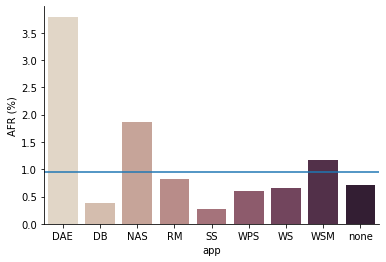

In [153]:
df_plotAFRMTTFSPF = df_idAppsSSDs.loc[:,['app','AFR_SDDs', 'mttf_SDDs']]

#df_plotAFRMTTFSPF = df_plotAFRMTTFSPF.assign(spf_all='spf_ssds')

df_plotAFRMTTFSPF["AFR_SDDs"] = df_plotAFRMTTFSPF["AFR_SDDs"]*100

graph = sns.barplot(x = "app", y = 'AFR_SDDs', palette = 'ch:.25', data = df_plotAFRMTTFSPF, order=['DAE', 'DB', 'NAS', 'RM', 'SS', 'WPS', 'WS', 'WSM', 'none'])
graph.axhline(df_general_AFRMTTF.loc[df_general_AFRMTTF['FailedSSDsSet'] == 'FailedSSDs', 'AFR_General'].values[0]*100)
#graph.set_ylabel("Gender",size = 67,color="g",alpha=0.5)
graph.set_ylabel("AFR (%)")
sns.despine()
plt.show()

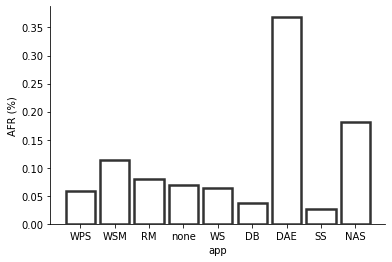

In [155]:
# The same analysis above, however, this time using 'histplot' to use the stat parameter to normalize the bars.

df_plotAFRMTTFSPF = df_idAppsSSDs.loc[:,['app','AFR_SDDs', 'mttf_SDDs']]

#df_plotAFRMTTFSPF = df_plotAFRMTTFSPF.assign(spf_all='spf_ssds')

df_plotAFRMTTFSPF["AFR_SDDs"] = df_plotAFRMTTFSPF["AFR_SDDs"]*100

graph = sns.histplot(df_plotAFRMTTFSPF, x = "app", linewidth=2.5, facecolor=(1, 1, 1, 0),
                 edgecolor=".2", weights='AFR_SDDs', shrink=0.85, stat="density", common_norm=True)
#graph.axhline(df_general_AFRMTTF.loc[df_general_AFRMTTF['FailedSSDsSet'] == 'FailedSSDs', 'AFR_General'].values[0]*100)
#graph.set_ylabel("Gender",size = 67,color="g",alpha=0.5)
graph.set_ylabel("AFR (%)")
sns.despine()
plt.show()

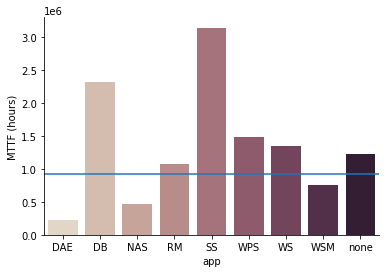

In [156]:
graph = sns.barplot(x = "app", y = 'mttf_SDDs', palette = 'ch:.25', data = df_plotAFRMTTFSPF, order=['DAE', 'DB', 'NAS', 'RM', 'SS', 'WPS', 'WS', 'WSM', 'none'])
graph.axhline(df_general_AFRMTTF.loc[df_general_AFRMTTF['FailedSSDsSet'] == 'FailedSSDs', 'MTTF_General'].values[0])
graph.set_ylabel("MTTF (hours)")
sns.despine()
plt.show()

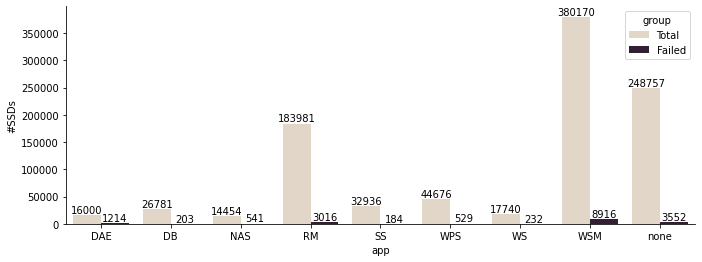

In [151]:
df_plotNSDDsFailedTotal1 = df_idAppsSSDs.loc[:,['app','N_AllSSDsApp']]
df_plotNSDDsFailedTotal2 = df_idAppsSSDs.loc[:,['app','N_failed_SDDs']]

df_plotNSDDsFailedTotal1 = df_plotNSDDsFailedTotal1.assign(group='Total')
df_plotNSDDsFailedTotal2 = df_plotNSDDsFailedTotal2.assign(group='Failed')
df_plotNSDDsFailedTotal2.rename(columns = {'N_failed_SDDs':'N_AllSSDsApp'}, inplace=True)

df_plotNSDDsFailedTotal1 = pd.concat([df_plotNSDDsFailedTotal1,df_plotNSDDsFailedTotal2])
#df_plotNSDDsFailedTotal1["N_AllSSDsApp"] = df_plotNSDDsFailedTotal1["N_AllSSDsApp"]

graph = sns.barplot(x = "app", y = 'N_AllSSDsApp', palette = 'ch:.25', hue = 'group', data = df_plotNSDDsFailedTotal1, order=['DAE', 'DB', 'NAS', 'RM', 'SS', 'WPS', 'WS', 'WSM', 'none'])
for container in graph.containers:
    graph.bar_label(container, label_type='edge')
graph.set_ylabel("#SSDs")
graph.figure.set_figwidth(11.27) # increasing the figure width
#graph.fig.set_figheight(11.7)
sns.despine()
plt.show()

#df_plotNSDDsFailedTotal1.head(20)

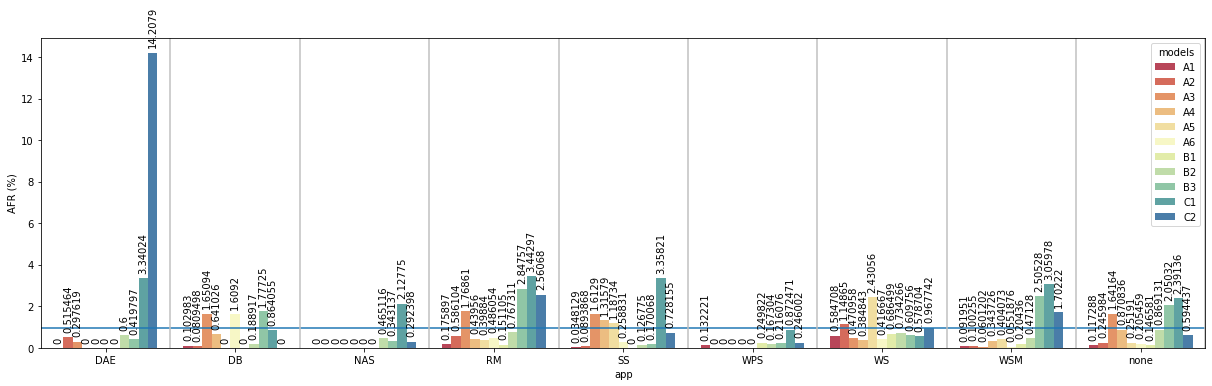

In [327]:
### To plot the AFR per application for each SSD models

df_temp = df_idModelsSSDs.copy()
df_temp["AFR_SDDs"] = df_temp["AFR_SDDs"]*100

graph = sns.barplot(x = "app", y = 'AFR_SDDs', palette = 'Spectral', hue = 'models', data = df_temp, hue_order = ['A1','A2','A3','A4','A5','A6','B1','B2','B3','C1','C2'], order=['DAE', 'DB', 'NAS', 'RM', 'SS', 'WPS', 'WS', 'WSM', 'none'])
for container in graph.containers:
    graph.bar_label(container, label_type='edge', rotation='vertical', padding=5)

graph.axhline(df_general_AFRMTTF.loc[df_general_AFRMTTF['FailedSSDsSet'] == 'FailedSSDs', 'AFR_General'].values[0]*100)
graph.set_ylabel("AFR (%)")
#graph.figure.set_figwidth(14.87) # increasing the figure width
graph.figure.set_figwidth(20.87) # increasing the figure width
graph.figure.set_figheight(5.7)
[graph.axvline(x+.5,color='silver') for x in graph.get_xticks()]
#sns.despine()
plt.show()



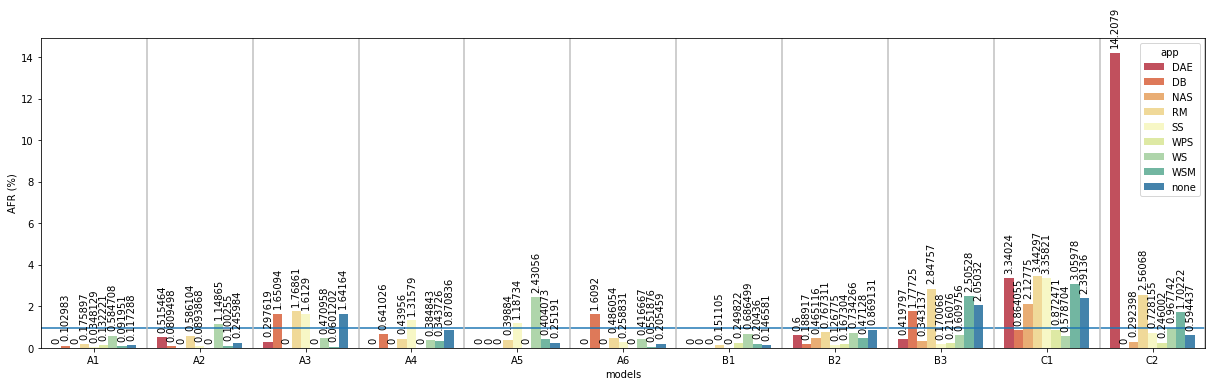

In [452]:
### To plot the AFR per SSD models for each application

df_temp = df_idModelsSSDs.copy()
df_temp["AFR_SDDs"] = df_temp["AFR_SDDs"]*100

graph = sns.barplot(x = "models", y = 'AFR_SDDs', palette = 'Spectral', hue = 'app', data = df_temp, order = ['A1','A2','A3','A4','A5','A6','B1','B2','B3','C1','C2'], hue_order=['DAE', 'DB', 'NAS', 'RM', 'SS', 'WPS', 'WS', 'WSM', 'none'])
for container in graph.containers:
    graph.bar_label(container, label_type='edge', rotation='vertical', padding=5)

graph.axhline(df_general_AFRMTTF.loc[df_general_AFRMTTF['FailedSSDsSet'] == 'FailedSSDs', 'AFR_General'].values[0]*100)
graph.set_ylabel("AFR (%)")
#graph.figure.set_figwidth(14.87) # increasing the figure width
graph.figure.set_figwidth(20.87) # increasing the figure width
graph.figure.set_figheight(5.7)
[graph.axvline(x+.5,color='silver') for x in graph.get_xticks()]
#sns.despine()
plt.show()

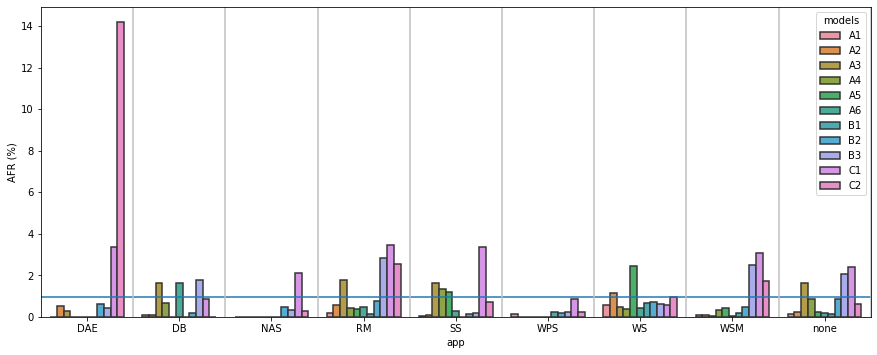

In [300]:
### To plot the AFR per SSD models for each application - normalized

df_temp = df_idModelsSSDs.copy()
df_temp["AFR_SDDs"] = df_temp["AFR_SDDs"]*100

#graph = sns.barplot(x = "app", y = 'AFR_SDDs', palette = 'Spectral', hue = 'models', data = df_temp, hue_order = ['A1','A2','A3','A4','A5','A6','B1','B2','B3','C1','C2'])
graph = sns.barplot(x = "app", y = 'AFR_SDDs', linewidth=1.5,
                edgecolor=".2", hue = 'models', data = df_temp, hue_order = ['A1','A2','A3','A4','A5','A6','B1','B2','B3','C1','C2'], order=['DAE', 'DB', 'NAS', 'RM', 'SS', 'WPS', 'WS', 'WSM', 'none'])

#for container in graph.containers:
#    graph.bar_label(container, label_type='edge')

graph.axhline(df_general_AFRMTTF.loc[df_general_AFRMTTF['FailedSSDsSet'] == 'FailedSSDs', 'AFR_General'].values[0]*100)
graph.set_ylabel("AFR (%)")
graph.figure.set_figwidth(14.87) # increasing the figure width
graph.figure.set_figheight(5.7)
[graph.axvline(x+.5,color='silver') for x in graph.get_xticks()]
#sns.despine()
plt.show()

/usr/local/lib/python3.8/dist-packages/pandas/core/arrays/categorical.py:2747: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


Text(0, 0.5, 'AFR (%)')

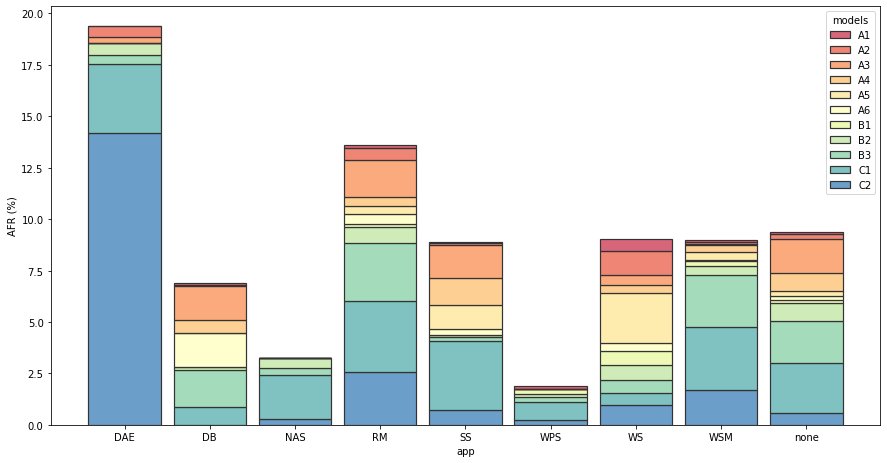

In [299]:
### To plot the AFR per SSD models for each application using stacking approach

df_temp = df_idModelsSSDs.copy()
df_temp["AFR_SDDs"] = df_temp["AFR_SDDs"]*100

order1 = ['DAE', 'DB', 'NAS', 'RM', 'SS', 'WPS', 'WS', 'WSM', 'none']
df_temp.app = df_temp.app.astype("category")
df_temp.app.cat.set_categories(order1, inplace=True)
df_temp.sort_values(by='app')

ax = sns.histplot(
    df_temp,
    x='app',
    # Use the value variable here to turn histogram counts into weighted
    # values.
    weights='AFR_SDDs',
    hue='models',
    #multiple='dodge',   bars
    #multiple='layer',
    multiple='stack',
    #multiple='fill',
    palette='Spectral',
    #palette='icefire',
    #palette='husl',
    # Add white borders to the bars.
    #edgecolor='white',
    linewidth=1.2,
    edgecolor=".2",
    # Shrink the bars a bit so they don't touch.
    shrink=0.85,
    hue_order = ['A1','A2','A3','A4','A5','A6','B1','B2','B3','C1','C2'],
    
)
#ax.axhline(df_general_AFRMTTF.loc[df_general_AFRMTTF['FailedSSDsSet'] == 'FailedSSDs', 'AFR_General'].values[0]*100)
ax.figure.set_figwidth(14.87) # increasing the figure width
ax.figure.set_figheight(7.7)
#ax.set_title('Tips by Day and Gender')
# Remove 'Count' ylabel.
ax.set_ylabel("AFR (%)")

/usr/local/lib/python3.8/dist-packages/pandas/core/arrays/categorical.py:2747: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


Text(0, 0.5, 'Density')

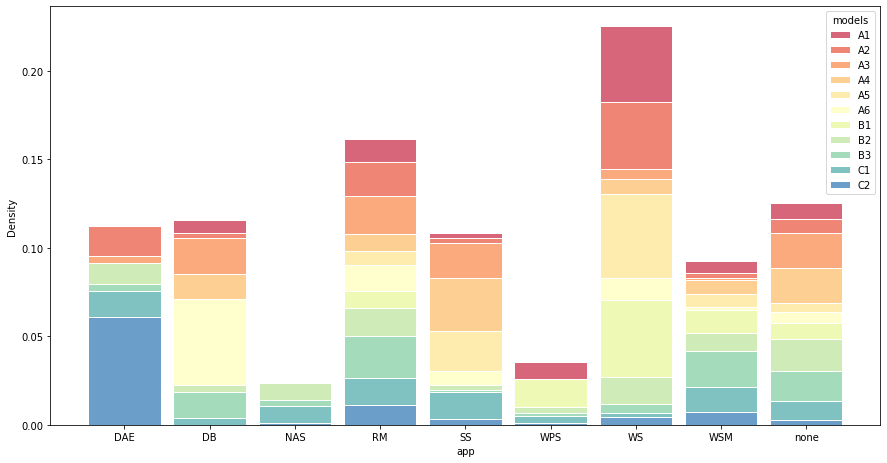

In [298]:
### To plot the AFR per SSD models for each application using stacking approach - normalized

df_temp = df_idModelsSSDs.copy()
df_temp["AFR_SDDs"] = df_temp["AFR_SDDs"]*100

order1 = ['DAE', 'DB', 'NAS', 'RM', 'SS', 'WPS', 'WS', 'WSM', 'none']
df_temp.app = df_temp.app.astype("category")
df_temp.app.cat.set_categories(order1, inplace=True)
df_temp.sort_values(by='app')

ax = sns.histplot(
    df_temp,
    x='app',
    # Use the value variable here to turn histogram counts into weighted
    # values.
    weights='AFR_SDDs',
    hue='models',
    multiple='stack',
    palette='Spectral',
    #palette='icefire',
    #palette='husl',
    # Add white borders to the bars.
    edgecolor='white',
    # Shrink the bars a bit so they don't touch.
    shrink=0.85,
    hue_order = ['A1','A2','A3','A4','A5','A6','B1','B2','B3','C1','C2'],
    stat="density", common_norm=True
)
#ax.axhline(df_general_AFRMTTF.loc[df_general_AFRMTTF['FailedSSDsSet'] == 'FailedSSDs', 'AFR_General'].values[0]*100)
ax.figure.set_figwidth(14.87) # increasing the figure width
ax.figure.set_figheight(7.7)
#ax.set_title('Tips by Day and Gender')
# Remove 'Count' ylabel.
ax.set_ylabel("Density")

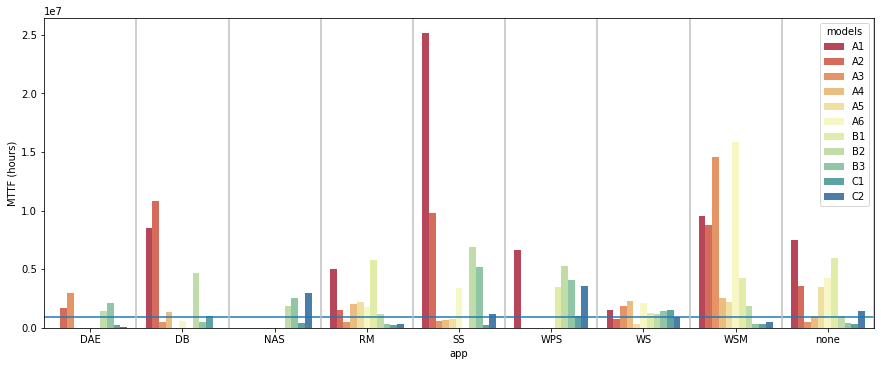

In [301]:
### To plot the MTTF per SSD models for each application

graph = sns.barplot(x = "app", y = 'mttf_SDDs', palette = 'Spectral', hue = 'models', data = df_idModelsSSDs, hue_order = ['A1','A2','A3','A4','A5','A6','B1','B2','B3','C1','C2'], order=['DAE', 'DB', 'NAS', 'RM', 'SS', 'WPS', 'WS', 'WSM', 'none'])
#for container in graph.containers:
#    graph.bar_label(container, label_type='edge')

graph.axhline(df_general_AFRMTTF.loc[df_general_AFRMTTF['FailedSSDsSet'] == 'FailedSSDs', 'MTTF_General'].values[0])
graph.set_ylabel("MTTF (hours)")
graph.figure.set_figwidth(14.87) # increasing the figure width
graph.figure.set_figheight(5.7)
[graph.axvline(x+.5,color='silver') for x in graph.get_xticks()]
#sns.despine()
plt.show()

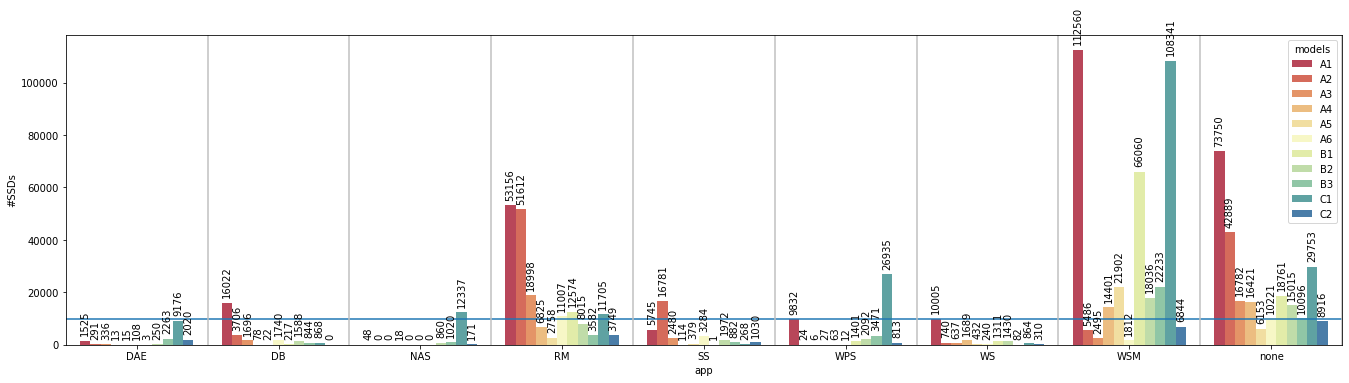

In [350]:
### To plot the number of SSD models for each application

df_temp = df_idModelsSSDs.copy()
#df_temp["AFR_SDDs"] = df_temp["AFR_SDDs"]*100

graph = sns.barplot(x = "app", y = 'N_AllSSDsApp', palette = 'Spectral', hue = 'models', data = df_temp, hue_order = ['A1','A2','A3','A4','A5','A6','B1','B2','B3','C1','C2'], order=['DAE', 'DB', 'NAS', 'RM', 'SS', 'WPS', 'WS', 'WSM', 'none'])
for container in graph.containers:
    graph.bar_label(container, label_type='edge', rotation='vertical', padding=5)

graph.axhline(df_idModelsSSDs.N_AllSSDsApp.mean())
graph.set_ylabel("#SSDs")
graph.figure.set_figwidth(22.87) # increasing the figure width
#graph.figure.set_figwidth(14.87) # increasing the figure width
graph.figure.set_figheight(5.7)
[graph.axvline(x+.5,color='silver') for x in graph.get_xticks()]
#sns.despine()
plt.show()

In [361]:
df_idModelsSSDs.head(20)

,app,models,N_AllSSDsApp,N_failed_SDDs,AFR_SDDs,mttf_SDDs
0,WPS,A1,9832,26,0.001322,6625255.384615
1,WSM,A1,112560,207,0.00092,9526817.391304
2,RM,A1,53156,187,0.001759,4980177.112299
3,none,A1,73750,173,0.001173,7468786.127168
4,WS,A1,10005,117,0.005847,1498184.615385
5,DB,A1,16022,33,0.00103,8506225.454545
6,DAE,A1,1525,0,0,0
7,SS,A1,5745,4,0.000348,25163100.0
8,NAS,A1,48,0,0,0
9,WPS,A2,24,0,0,0


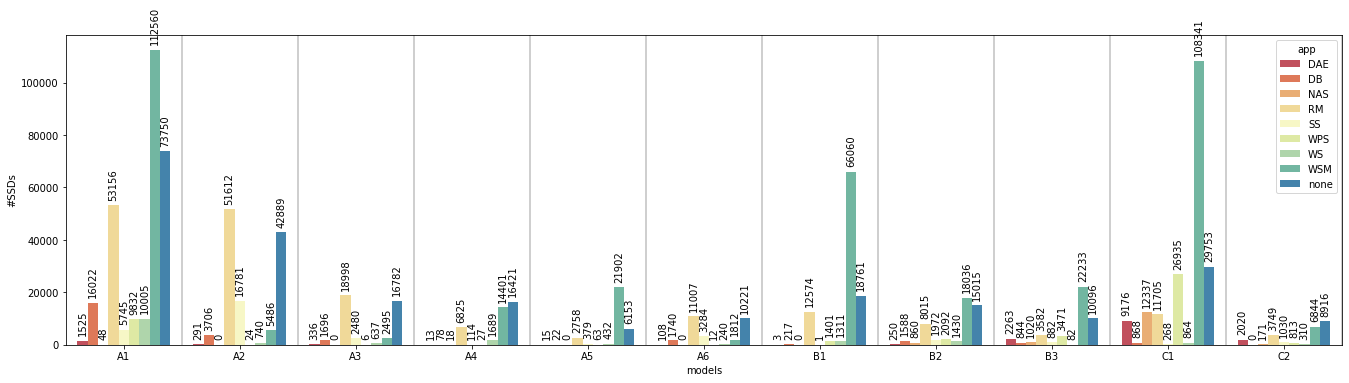

In [355]:
### To plot the number of devices per SSD models for each application

df_temp = df_idModelsSSDs.copy()
#df_temp["AFR_SDDs"] = df_temp["AFR_SDDs"]*100

graph = sns.barplot(x = "models", y = 'N_AllSSDsApp', palette = 'Spectral', hue = 'app', data = df_temp, order = ['A1','A2','A3','A4','A5','A6','B1','B2','B3','C1','C2'], hue_order=['DAE', 'DB', 'NAS', 'RM', 'SS', 'WPS', 'WS', 'WSM', 'none'])
for container in graph.containers:
    graph.bar_label(container, label_type='edge', rotation='vertical', padding=5)

#graph.axhline(df_idModelsSSDs.N_AllSSDsApp.mean())
graph.set_ylabel("#SSDs")
graph.figure.set_figwidth(22.87) # increasing the figure width
#graph.figure.set_figwidth(14.87) # increasing the figure width
graph.figure.set_figheight(5.7)
[graph.axvline(x+.5,color='silver') for x in graph.get_xticks()]
#sns.despine()
plt.show()

/usr/local/lib/python3.8/dist-packages/pandas/core/arrays/categorical.py:2747: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


Text(0, 0.5, '#SDDs')

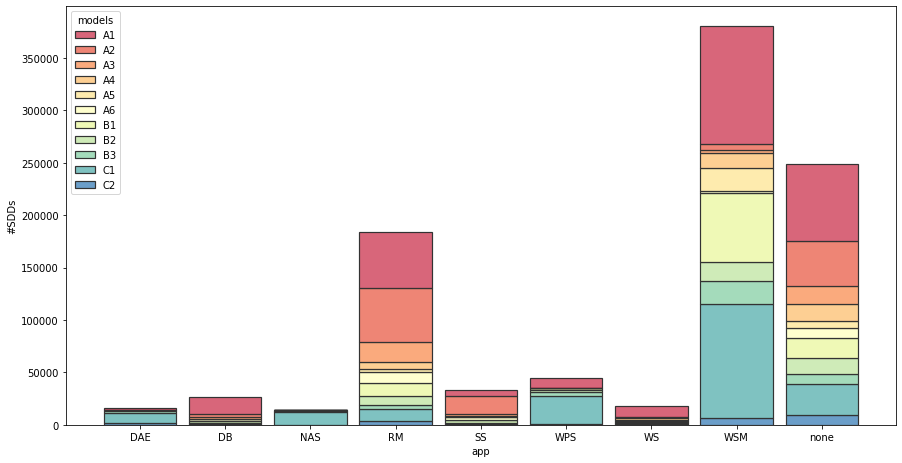

In [295]:
### To plot the number of SSD models for each application using stacking approach

df_temp = df_idModelsSSDs.copy()
#df_temp["AFR_SDDs"] = df_temp["AFR_SDDs"]*100

order1 = ['DAE', 'DB', 'NAS', 'RM', 'SS', 'WPS', 'WS', 'WSM', 'none']
df_temp.app = df_temp.app.astype("category")
df_temp.app.cat.set_categories(order1, inplace=True)
df_temp.sort_values(by='app')

ax = sns.histplot(
    df_temp,
    x='app',
    # Use the value variable here to turn histogram counts into weighted
    # values.
    weights='N_AllSSDsApp',
    hue='models',
    #multiple='dodge',   bars
    #multiple='layer',
    multiple='stack',
    #multiple='fill',
    palette='Spectral',
    #palette='icefire',
    #palette='husl',
    # Add white borders to the bars.
    #edgecolor='white',
    linewidth=1.2,
    edgecolor=".2",
    # Shrink the bars a bit so they don't touch.
    shrink=0.85,
    hue_order = ['A1','A2','A3','A4','A5','A6','B1','B2','B3','C1','C2']
)
#ax.axhline(df_general_AFRMTTF.loc[df_general_AFRMTTF['FailedSSDsSet'] == 'FailedSSDs', 'AFR_General'].values[0]*100)
ax.figure.set_figwidth(14.87) # increasing the figure width
ax.figure.set_figheight(7.7)
#ax.set_title('Tips by Day and Gender')
# Remove 'Count' ylabel.
ax.set_ylabel("#SDDs")

/usr/local/lib/python3.8/dist-packages/pandas/core/arrays/categorical.py:2747: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


Text(0, 0.5, 'Density')

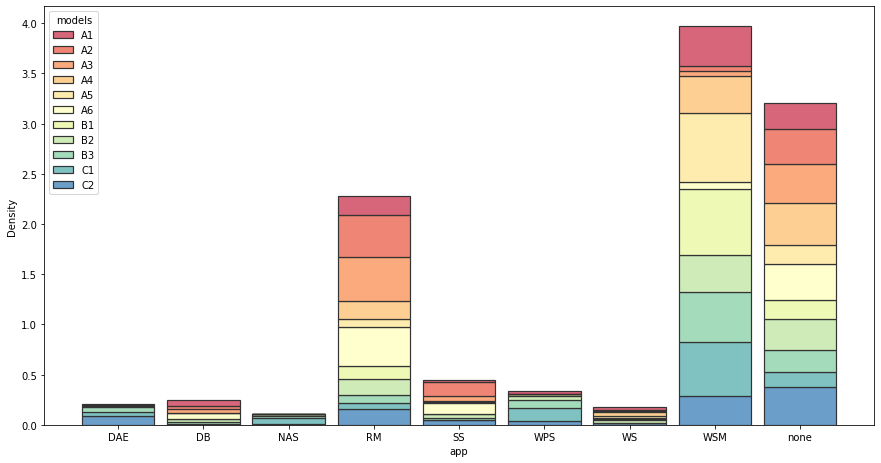

In [308]:
### To plot the number of SSD models for each application using stacking approach - normalized

df_temp = df_idModelsSSDs.copy()
#df_temp["AFR_SDDs"] = df_temp["AFR_SDDs"]*100

order1 = ['DAE', 'DB', 'NAS', 'RM', 'SS', 'WPS', 'WS', 'WSM', 'none']
df_temp.app = df_temp.app.astype("category")
df_temp.app.cat.set_categories(order1, inplace=True)
df_temp.sort_values(by='app')

ax = sns.histplot(
    df_temp,
    x='app',
    # Use the value variable here to turn histogram counts into weighted
    # values.
    weights='N_AllSSDsApp',
    hue='models',
    #multiple='dodge',   bars
    #multiple='layer',
    multiple='stack',
    #multiple='fill',
    palette='Spectral',
    #palette='icefire',
    #palette='husl',
    # Add white borders to the bars.
    #edgecolor='white',
    linewidth=1.2,
    edgecolor=".2",
    # Shrink the bars a bit so they don't touch.
    shrink=0.85,
    hue_order = ['A1','A2','A3','A4','A5','A6','B1','B2','B3','C1','C2'],
    stat="density", common_norm=False
    
)
#ax.axhline(df_general_AFRMTTF.loc[df_general_AFRMTTF['FailedSSDsSet'] == 'FailedSSDs', 'AFR_General'].values[0]*100)
ax.figure.set_figwidth(14.87) # increasing the figure width
ax.figure.set_figheight(7.7)
#ax.set_title('Tips by Day and Gender')
# Remove 'Count' ylabel.
ax.set_ylabel("Density")

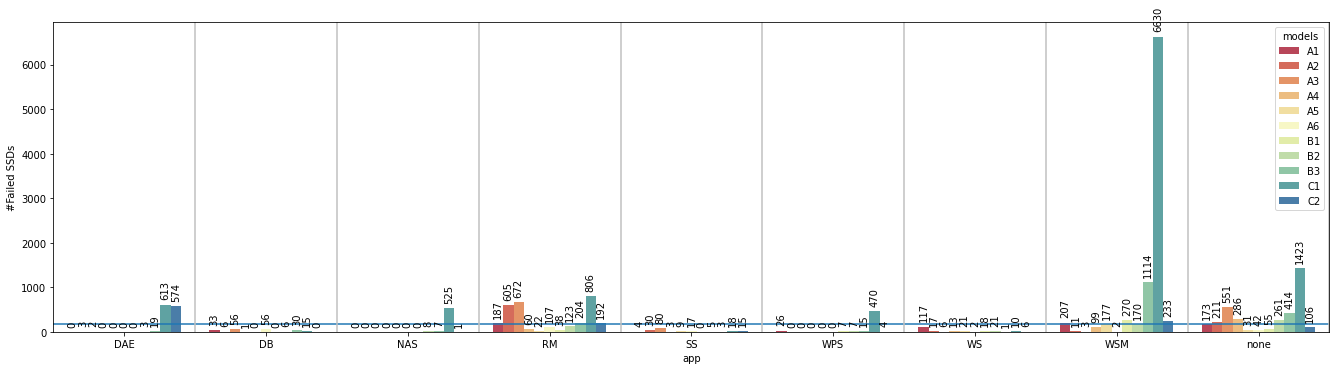

In [349]:
### To plot the number of failed SSD models for each application

df_temp = df_idModelsSSDs.copy()
#df_temp["AFR_SDDs"] = df_temp["AFR_SDDs"]*100

graph = sns.barplot(x = "app", y = 'N_failed_SDDs', palette = 'Spectral', hue = 'models', data = df_temp, hue_order = ['A1','A2','A3','A4','A5','A6','B1','B2','B3','C1','C2'], order=['DAE', 'DB', 'NAS', 'RM', 'SS', 'WPS', 'WS', 'WSM', 'none'])
for container in graph.containers:
    graph.bar_label(container, label_type='edge', rotation='vertical', padding=5)

graph.axhline(df_idModelsSSDs.N_failed_SDDs.mean())
graph.set_ylabel("#Failed SSDs")
#graph.figure.set_figwidth(14.87) # increasing the figure width
graph.figure.set_figwidth(22.87) # increasing the figure width
graph.figure.set_figheight(5.7)
[graph.axvline(x+.5,color='silver') for x in graph.get_xticks()]
#sns.despine()
plt.show()

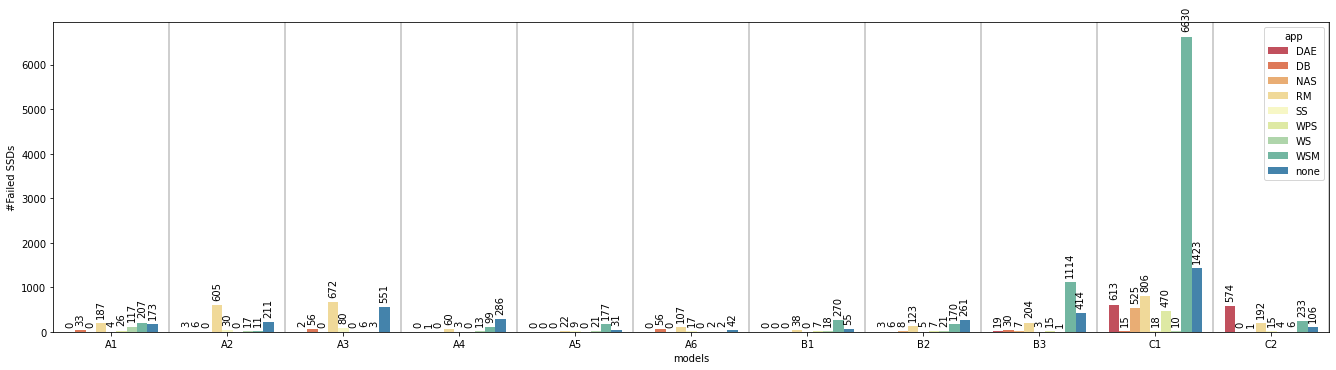

In [356]:
### To plot the number of failed devices per SSD models for each application

df_temp = df_idModelsSSDs.copy()
#df_temp["AFR_SDDs"] = df_temp["AFR_SDDs"]*100

graph = sns.barplot(x = "models", y = 'N_failed_SDDs', palette = 'Spectral', hue = 'app', data = df_temp, order = ['A1','A2','A3','A4','A5','A6','B1','B2','B3','C1','C2'], hue_order=['DAE', 'DB', 'NAS', 'RM', 'SS', 'WPS', 'WS', 'WSM', 'none'])
for container in graph.containers:
    graph.bar_label(container, label_type='edge', rotation='vertical', padding=5)

#graph.axhline(df_idModelsSSDs.N_failed_SDDs.mean())
graph.set_ylabel("#Failed SSDs")
#graph.figure.set_figwidth(14.87) # increasing the figure width
graph.figure.set_figwidth(22.87) # increasing the figure width
graph.figure.set_figheight(5.7)
[graph.axvline(x+.5,color='silver') for x in graph.get_xticks()]
#sns.despine()
plt.show()

/usr/local/lib/python3.8/dist-packages/pandas/core/arrays/categorical.py:2747: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


Text(0, 0.5, '#Failed SDDs')

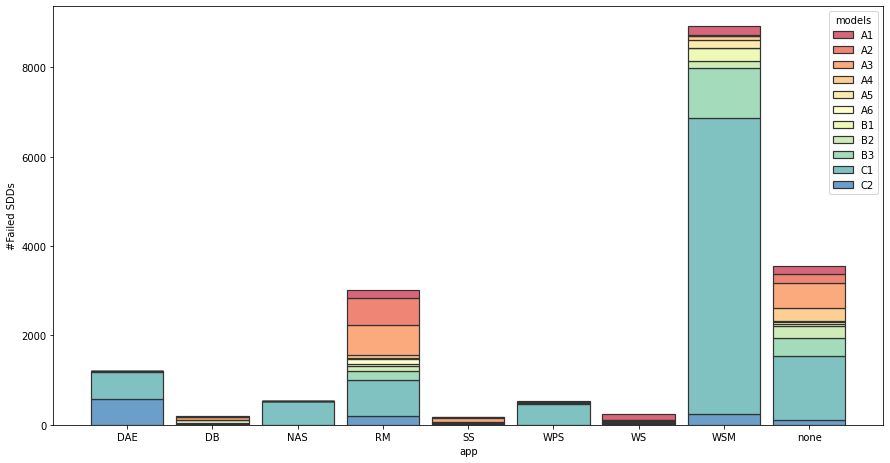

In [302]:
### To plot the number of SSD models for each application using stacking approach

df_temp = df_idModelsSSDs.copy()
#df_temp["AFR_SDDs"] = df_temp["AFR_SDDs"]*100

order1 = ['DAE', 'DB', 'NAS', 'RM', 'SS', 'WPS', 'WS', 'WSM', 'none']
df_temp.app = df_temp.app.astype("category")
df_temp.app.cat.set_categories(order1, inplace=True)
df_temp.sort_values(by='app')

ax = sns.histplot(
    df_temp,
    x='app',
    # Use the value variable here to turn histogram counts into weighted
    # values.
    weights='N_failed_SDDs',
    hue='models',
    #multiple='dodge',   bars
    #multiple='layer',
    multiple='stack',
    #multiple='fill',
    palette='Spectral',
    #palette='icefire',
    #palette='husl',
    # Add white borders to the bars.
    #edgecolor='white',
    linewidth=1.2,
    edgecolor=".2",
    # Shrink the bars a bit so they don't touch.
    shrink=0.85,
    hue_order = ['A1','A2','A3','A4','A5','A6','B1','B2','B3','C1','C2'],
    
)
#ax.axhline(df_general_AFRMTTF.loc[df_general_AFRMTTF['FailedSSDsSet'] == 'FailedSSDs', 'AFR_General'].values[0]*100)
ax.figure.set_figwidth(14.87) # increasing the figure width
ax.figure.set_figheight(7.7)
#ax.set_title('Tips by Day and Gender')
# Remove 'Count' ylabel.
ax.set_ylabel("#Failed SDDs")

/usr/local/lib/python3.8/dist-packages/pandas/core/arrays/categorical.py:2747: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


Text(0, 0.5, 'Density')

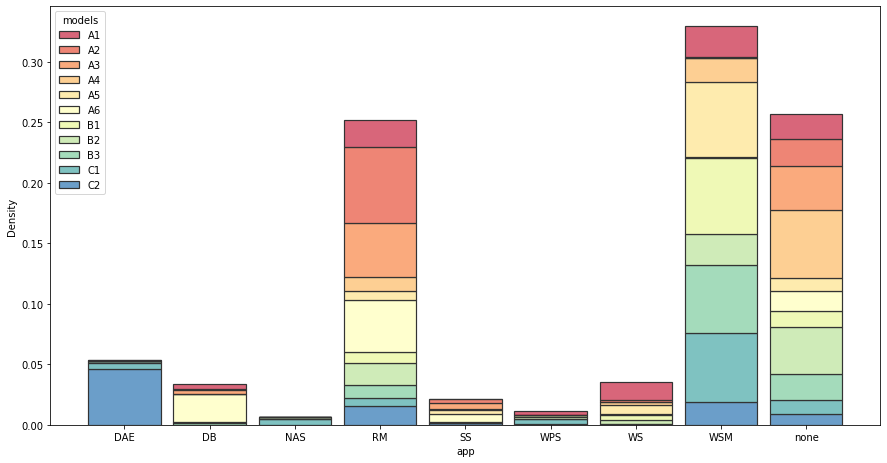

In [303]:
### To plot the number of SSD models for each application using stacking approach - normalized

df_temp = df_idModelsSSDs.copy()
#df_temp["AFR_SDDs"] = df_temp["AFR_SDDs"]*100

order1 = ['DAE', 'DB', 'NAS', 'RM', 'SS', 'WPS', 'WS', 'WSM', 'none']
df_temp.app = df_temp.app.astype("category")
df_temp.app.cat.set_categories(order1, inplace=True)
df_temp.sort_values(by='app')

ax = sns.histplot(
    df_temp,
    x='app',
    # Use the value variable here to turn histogram counts into weighted
    # values.
    weights='N_failed_SDDs',
    hue='models',
    #multiple='dodge',   bars
    #multiple='layer',
    multiple='stack',
    #multiple='fill',
    palette='Spectral',
    #palette='icefire',
    #palette='husl',
    # Add white borders to the bars.
    #edgecolor='white',
    linewidth=1.2,
    edgecolor=".2",
    # Shrink the bars a bit so they don't touch.
    shrink=0.85,
    hue_order = ['A1','A2','A3','A4','A5','A6','B1','B2','B3','C1','C2'],
    stat="density", common_norm=True
    
)
#ax.axhline(df_general_AFRMTTF.loc[df_general_AFRMTTF['FailedSSDsSet'] == 'FailedSSDs', 'AFR_General'].values[0]*100)
ax.figure.set_figwidth(14.87) # increasing the figure width
ax.figure.set_figheight(7.7)
#ax.set_title('Tips by Day and Gender')
# Remove 'Count' ylabel.
ax.set_ylabel("Density")

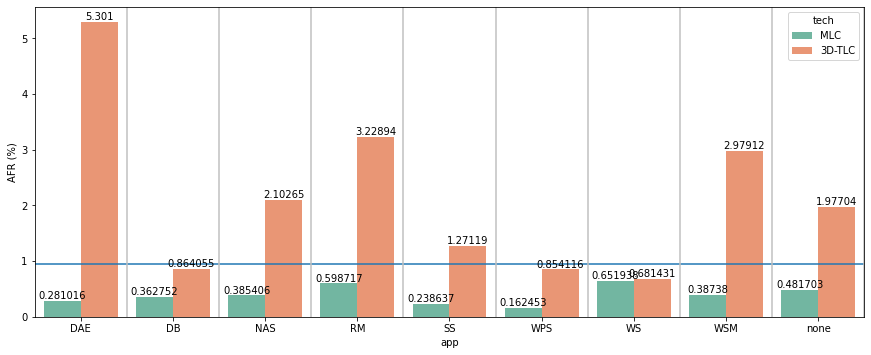

In [239]:
### To plot the AFR per SSD flash technology for each application

df_temp3Plot = df_idTechSSDs.copy()
df_temp3Plot["AFR_SSDs"] = df_temp3Plot["AFR_SSDs"]*100
graph = sns.barplot(x = "app", y = 'AFR_SSDs', palette = 'Set2', hue = 'tech', data = df_temp3Plot, hue_order = ['MLC','3D-TLC'])

for container in graph.containers:
    graph.bar_label(container, label_type='edge')


graph.set_ylabel("AFR (%)")
graph.axhline(df_general_AFRMTTF.loc[df_general_AFRMTTF['FailedSSDsSet'] == 'FailedSSDs', 'AFR_General'].values[0]*100)
graph.figure.set_figwidth(14.87) # increasing the figure width
graph.figure.set_figheight(5.7)
[graph.axvline(x+.5,color='silver') for x in graph.get_xticks()]
#sns.despine()
plt.show()

Text(0, 0.5, 'AFR (%)')

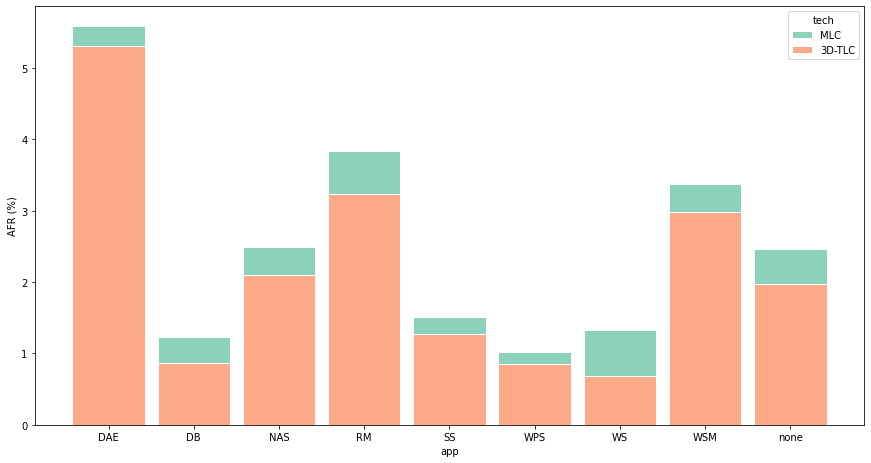

In [231]:
### To plot the AFR per SSD flash technology for each application using stacking approach

df_temp = df_idTechSSDs.copy()
df_temp["AFR_SSDs"] = df_temp["AFR_SSDs"]*100

ax = sns.histplot(
    df_temp,
    x='app',
    # Use the value variable here to turn histogram counts into weighted
    # values.
    weights='AFR_SSDs',
    hue='tech',
    multiple='stack',
    #palette='Spectral',
    #palette='icefire',
    #palette='husl',
    palette = 'Set2',
    # Add white borders to the bars.
    edgecolor='white',
    # Shrink the bars a bit so they don't touch.
    shrink=0.85,
    hue_order = ['MLC','3D-TLC']
)
ax.figure.set_figwidth(14.87) # increasing the figure width
ax.figure.set_figheight(7.7)
#ax.set_title('Tips by Day and Gender')
# Remove 'Count' ylabel.
ax.set_ylabel("AFR (%)")

Text(0, 0.5, 'Density')

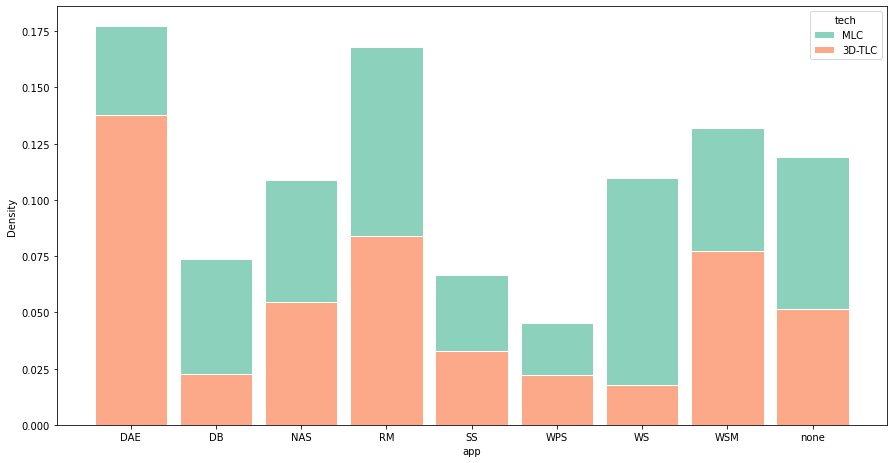

In [162]:
### To plot the AFR per SSD flash technology for each application using stacking approach

df_temp = df_idTechSSDs.copy()
df_temp["AFR_SSDs"] = df_temp["AFR_SSDs"]*100

ax = sns.histplot(
    df_temp,
    x='app',
    # Use the value variable here to turn histogram counts into weighted
    # values.
    weights='AFR_SSDs',
    hue='tech',
    multiple='stack',
    #palette='Spectral',
    #palette='icefire',
    #palette='husl',
    palette = 'Set2',
    # Add white borders to the bars.
    edgecolor='white',
    # Shrink the bars a bit so they don't touch.
    shrink=0.85,
    hue_order = ['MLC','3D-TLC'],
    stat="density", common_norm=True
)
ax.figure.set_figwidth(14.87) # increasing the figure width
ax.figure.set_figheight(7.7)
#ax.set_title('Tips by Day and Gender')
# Remove 'Count' ylabel.
ax.set_ylabel("Density")

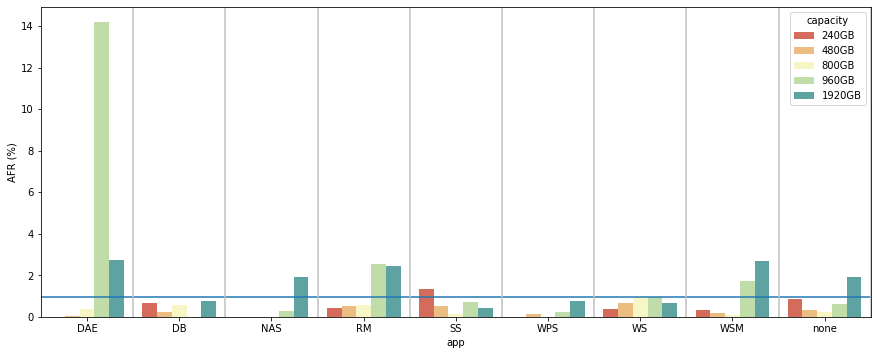

In [240]:
### To plot the AFR per SSD flash capacity for each application

df_temp3Plot = df_idCapacitySSDs.copy()
df_temp3Plot["AFR_SSDs"] = df_temp3Plot["AFR_SSDs"]*100
graph = sns.barplot(x = "app", y = 'AFR_SSDs', palette = 'Spectral', hue = 'capacity', data = df_temp3Plot, hue_order = ['240GB','480GB','800GB','960GB','1920GB'])

#for container in graph.containers:
#    graph.bar_label(container, label_type='edge')


graph.set_ylabel("AFR (%)")
graph.axhline(df_general_AFRMTTF.loc[df_general_AFRMTTF['FailedSSDsSet'] == 'FailedSSDs', 'AFR_General'].values[0]*100)
graph.figure.set_figwidth(14.87) # increasing the figure width
graph.figure.set_figheight(5.7)
[graph.axvline(x+.5,color='silver') for x in graph.get_xticks()]
#sns.despine()
plt.show()

Text(0, 0.5, 'AFR (%)')

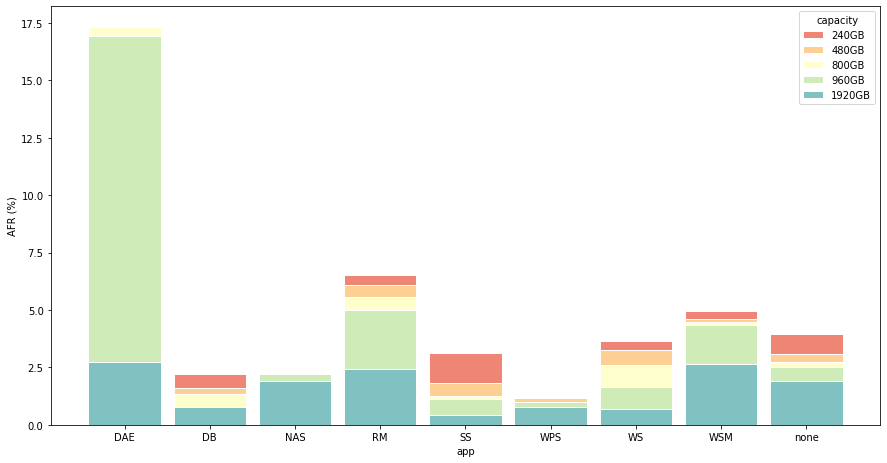

In [243]:
### To plot the AFR per SSD flash capacity for each application using stacking approach

df_temp = df_idCapacitySSDs.copy()
df_temp["AFR_SSDs"] = df_temp["AFR_SSDs"]*100

ax = sns.histplot(
    df_temp,
    x='app',
    # Use the value variable here to turn histogram counts into weighted
    # values.
    weights='AFR_SSDs',
    hue='capacity',
    multiple='stack',
    #palette='Spectral',
    #palette='icefire',
    #palette='husl',
    palette = 'Spectral',
    # Add white borders to the bars.
    edgecolor='white',
    # Shrink the bars a bit so they don't touch.
    shrink=0.85,
    hue_order = ['240GB','480GB','800GB','960GB','1920GB']
)
ax.figure.set_figwidth(14.87) # increasing the figure width
ax.figure.set_figheight(7.7)
#ax.set_title('Tips by Day and Gender')
# Remove 'Count' ylabel.
ax.set_ylabel("AFR (%)")

Text(0, 0.5, 'Density')

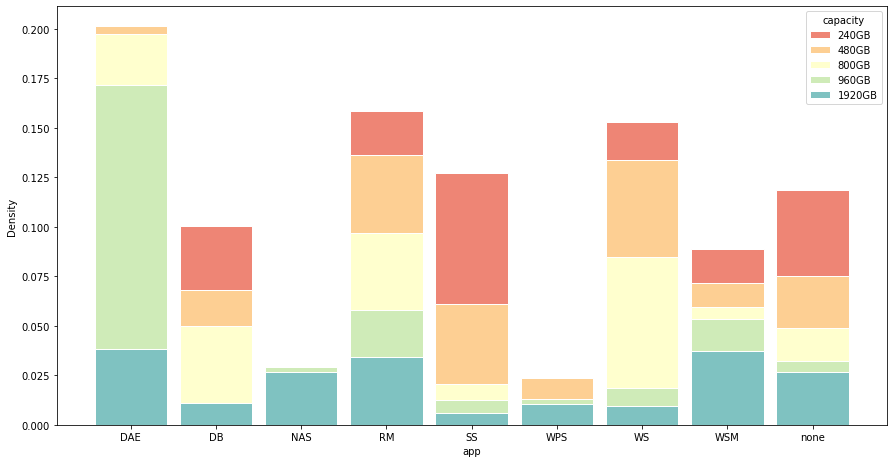

In [160]:
### To plot the AFR per SSD flash capacity for each application using stacking approach - normalized

df_temp = df_idCapacitySSDs.copy()
df_temp["AFR_SSDs"] = df_temp["AFR_SSDs"]*100

ax = sns.histplot(
    df_temp,
    x='app',
    # Use the value variable here to turn histogram counts into weighted
    # values.
    weights='AFR_SSDs',
    hue='capacity',
    multiple='stack',
    #palette='Spectral',
    #palette='icefire',
    #palette='husl',
    palette = 'Spectral',
    # Add white borders to the bars.
    edgecolor='white',
    # Shrink the bars a bit so they don't touch.
    shrink=0.85,
    hue_order = ['240GB','480GB','800GB','960GB','1920GB'],
    stat="density", common_norm=True
)
ax.figure.set_figwidth(14.87) # increasing the figure width
ax.figure.set_figheight(7.7)
#ax.set_title('Tips by Day and Gender')
# Remove 'Count' ylabel.
ax.set_ylabel("Density")

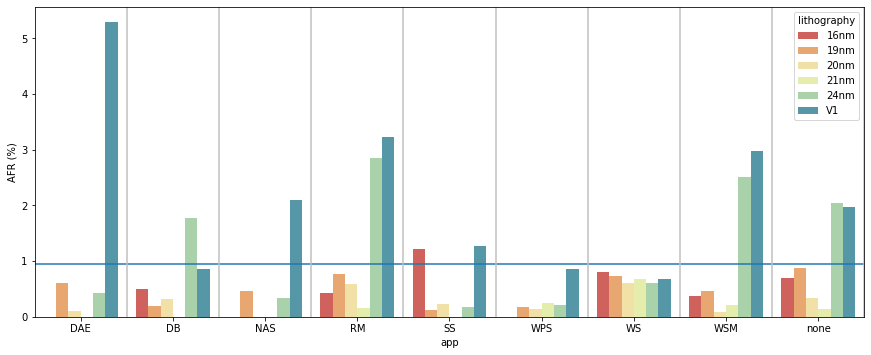

In [244]:
### To plot the AFR per SSD flash lithography for each application

df_temp3Plot = df_idLitSSDs.copy()
df_temp3Plot["AFR_SSDs"] = df_temp3Plot["AFR_SSDs"]*100
graph = sns.barplot(x = "app", y = 'AFR_SSDs', palette = 'Spectral', hue = 'lithography', data = df_temp3Plot, hue_order = ['16nm','19nm','20nm','21nm','24nm','V1'])

#for container in graph.containers:
#    graph.bar_label(container, label_type='edge')


graph.set_ylabel("AFR (%)")
graph.axhline(df_general_AFRMTTF.loc[df_general_AFRMTTF['FailedSSDsSet'] == 'FailedSSDs', 'AFR_General'].values[0]*100)
graph.figure.set_figwidth(14.87) # increasing the figure width
graph.figure.set_figheight(5.7)
[graph.axvline(x+.5,color='silver') for x in graph.get_xticks()]
#sns.despine()
plt.show()

Text(0, 0.5, 'AFR (%)')

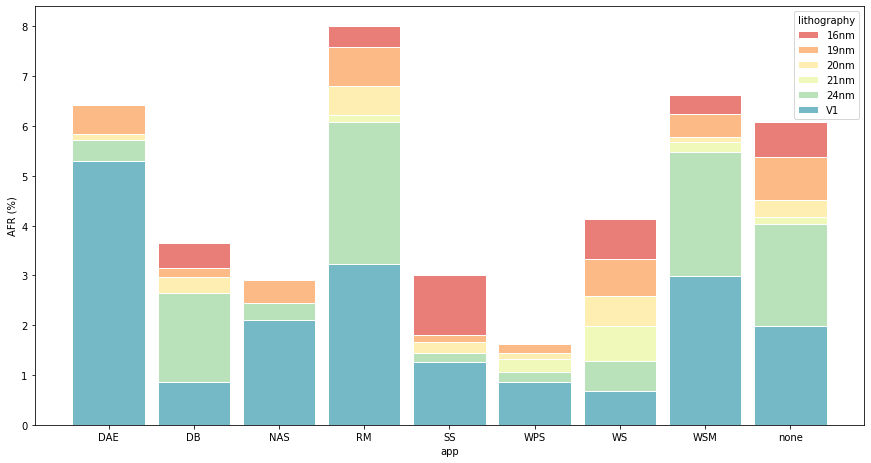

In [245]:
### To plot the AFR per SSD flash lithography for each application using stacking approach

df_temp = df_idLitSSDs.copy()
df_temp["AFR_SSDs"] = df_temp["AFR_SSDs"]*100

ax = sns.histplot(
    df_temp,
    x='app',
    # Use the value variable here to turn histogram counts into weighted
    # values.
    weights='AFR_SSDs',
    hue='lithography',
    multiple='stack',
    #palette='Spectral',
    #palette='icefire',
    #palette='husl',
    palette = 'Spectral',
    # Add white borders to the bars.
    edgecolor='white',
    # Shrink the bars a bit so they don't touch.
    shrink=0.85,
    hue_order = ['16nm','19nm','20nm','21nm','24nm','V1']
)
ax.figure.set_figwidth(14.87) # increasing the figure width
ax.figure.set_figheight(7.7)
#ax.set_title('Tips by Day and Gender')
# Remove 'Count' ylabel.
ax.set_ylabel("AFR (%)")

Text(0, 0.5, 'Density')

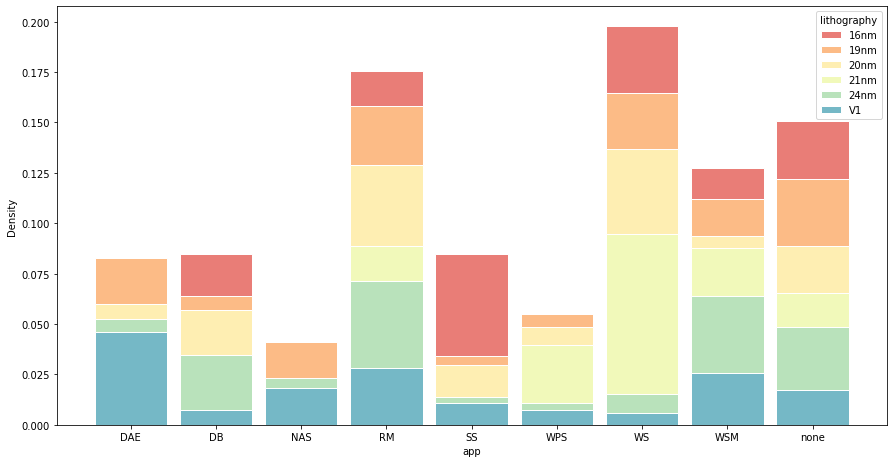

In [228]:
### To plot the AFR per SSD flash lithography for each application using stacking approach - normalized

df_temp = df_idLitSSDs.copy()
df_temp["AFR_SSDs"] = df_temp["AFR_SSDs"]*100

ax = sns.histplot(
    df_temp,
    x='app',
    # Use the value variable here to turn histogram counts into weighted
    # values.
    weights='AFR_SSDs',
    hue='lithography',
    multiple='stack',
    #palette='Spectral',
    #palette='icefire',
    #palette='husl',
    palette = 'Spectral',
    # Add white borders to the bars.
    edgecolor='white',
    # Shrink the bars a bit so they don't touch.
    shrink=0.85,
    hue_order = ['16nm','19nm','20nm','21nm','24nm','V1'],
    stat="density", common_norm=True
)
ax.figure.set_figwidth(14.87) # increasing the figure width
ax.figure.set_figheight(7.7)
#ax.set_title('Tips by Day and Gender')
# Remove 'Count' ylabel.
ax.set_ylabel("Density")

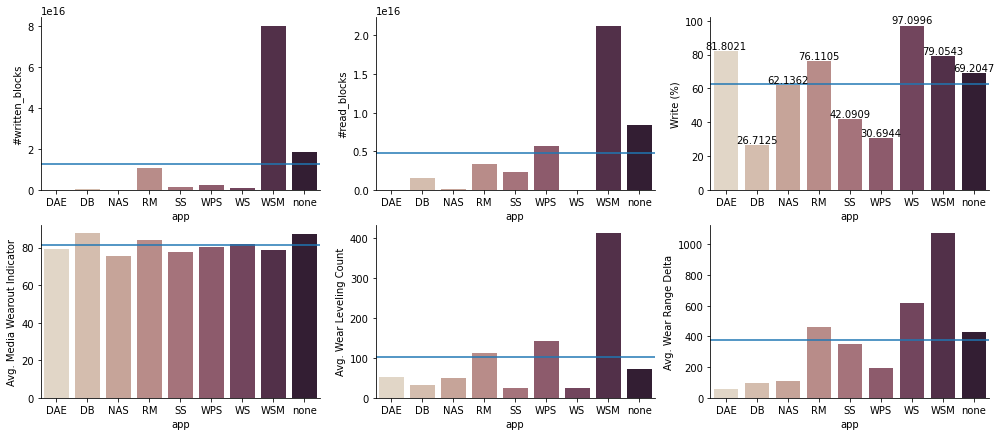

In [102]:
### To plot the number of write and read blocks for each application

df_temp = df_temp_blocks_writtenreadwear_app.copy()

#graph = sns.barplot(x = "app", y = 'n_b_written', palette = 'Spectral', data = df_temp)
#graph = sns.barplot(x = "app", y = 'n_b_read', palette = 'Spectral', data = df_temp)

graph, axs = plt.subplots(2, 3, figsize=(17, 7))

graph1 = sns.barplot(data=df_temp, x="app", y='n_b_written', palette='ch:.25', ax=axs[0,0])
graph2 = sns.barplot(data=df_temp, x="app", y='n_b_read', palette='ch:.25', ax=axs[0,1])
graph3 = sns.barplot(data=df_temp, x="app", y='%write', palette='ch:.25', ax=axs[0,2])
graph4 = sns.barplot(data=df_temp, x="app", y='media_wearout_i', palette='ch:.25', ax=axs[1,0])
graph5 = sns.barplot(data=df_temp, x="app", y='w_l_count', palette='ch:.25', ax=axs[1,1])
graph6 = sns.barplot(data=df_temp, x="app", y='w_r_d', palette='ch:.25', ax=axs[1,2])
#sns.histplot(data=df_temp, x="petal_length", kde=True, color="gold", ax=axs[1, 0])
#sns.histplot(data=df_temp, x="petal_width", kde=True, color="teal", ax=axs[1, 1])

for container in graph3.containers:
    graph3.bar_label(container, label_type='edge')

graph1.axhline((df_temp['n_b_written'].mean()))
graph2.axhline((df_temp['n_b_read'].mean()))
graph3.axhline((df_temp['%write'].mean()))
graph4.axhline((df_temp['media_wearout_i'].mean()))
graph5.axhline((df_temp['w_l_count'].mean()))
graph6.axhline((df_temp['w_r_d'].mean()))
graph1.set_ylabel("#written_blocks")
graph2.set_ylabel("#read_blocks")
graph3.set_ylabel("Write (%)")
graph4.set_ylabel("Avg. Media Wearout Indicator")
graph5.set_ylabel("Avg. Wear Leveling Count")
graph6.set_ylabel("Avg. Wear Range Delta")
#graph.figure.set_figwidth(14.87) # increasing the figure width
#graph.figure.set_figheight(5.7)
#[graph1.axvline(x+.5,color='silver') for x in graph1.get_xticks()]
sns.despine()
plt.show()



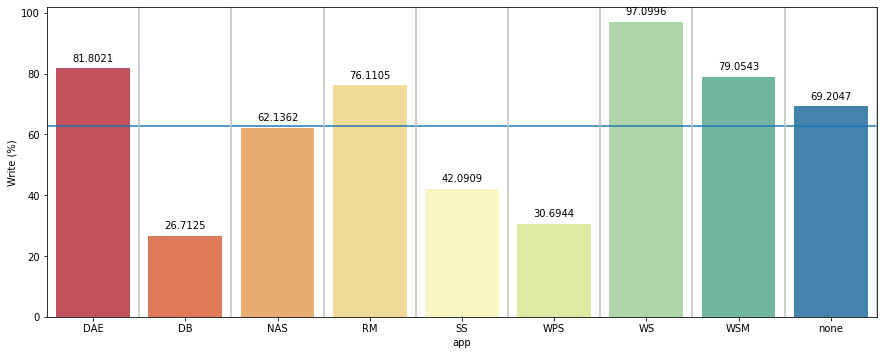

In [342]:
### To plot the number of write blocks for each application considering SSD models

df_temp = df_temp_blocks_writtenreadwear_app.copy()
#df_temp['n_b_written'] = (df_temp['n_b_written'])/(math.exp(1006))

graph = sns.barplot(x = "app", y = '%write', palette = 'Spectral', data = df_temp)
for container in graph.containers:
    graph.bar_label(container, label_type='edge', rotation='horizontal', padding=5)

graph.axhline((df_temp_blocks_writtenreadwear_app['%write'].mean()))
graph.set_ylabel("Write (%)")
graph.figure.set_figwidth(14.87) # increasing the figure width
#graph.figure.set_figwidth(22.87) # increasing the figure width
graph.figure.set_figheight(5.7)
[graph.axvline(x+.5,color='silver') for x in graph.get_xticks()]
#plt.legend(['models'])
#sns.despine()
plt.show()

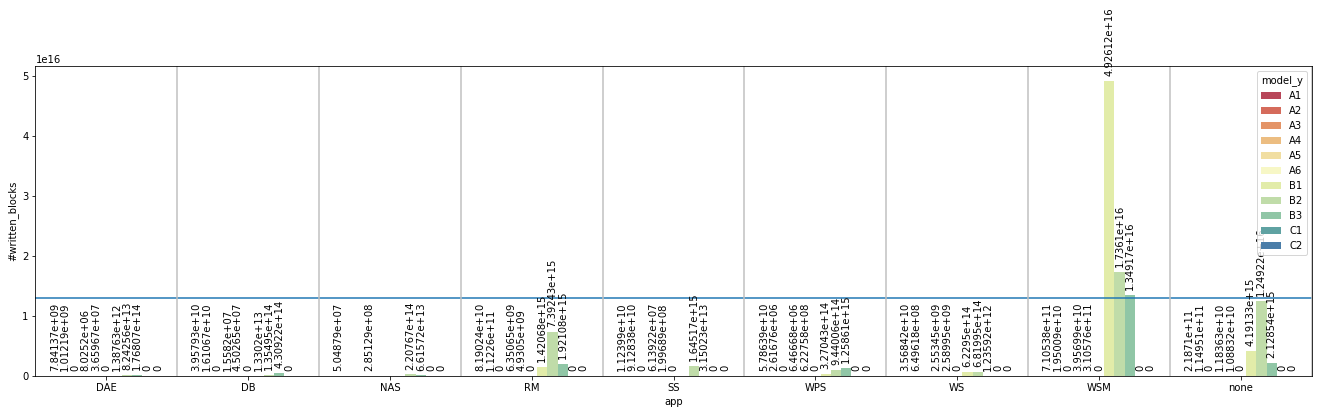

In [333]:
### To plot the number of write blocks for each application considering SSD models

df_temp = df_temp_blocks_writtenreadwear_appModel.copy()
#df_temp['n_b_written'] = (df_temp['n_b_written'])/(math.exp(1006))

graph = sns.barplot(x = "app", y = 'n_b_written', palette = 'Spectral', hue = 'model_y', data = df_temp, hue_order = ['A1','A2','A3','A4','A5','A6','B1','B2','B3','C1','C2'])
for container in graph.containers:
    graph.bar_label(container, label_type='edge', rotation='vertical', padding=5)

graph.axhline((df_temp_blocks_writtenreadwear_app['n_b_written'].mean()))
graph.set_ylabel("#written_blocks")
#graph.figure.set_figwidth(14.87) # increasing the figure width
graph.figure.set_figwidth(22.87) # increasing the figure width
graph.figure.set_figheight(5.7)
[graph.axvline(x+.5,color='silver') for x in graph.get_xticks()]
#plt.legend(['models'])
#sns.despine()
plt.show()



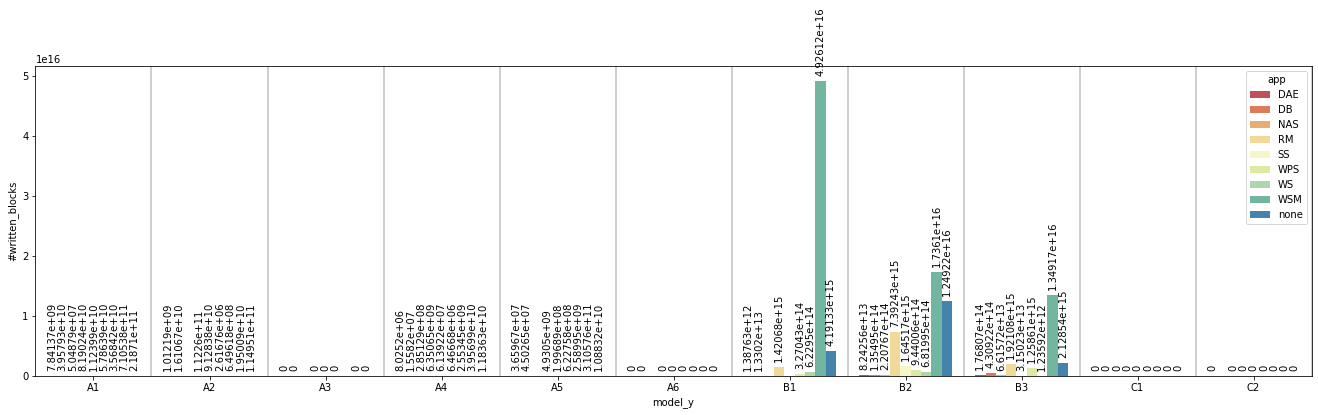

In [357]:
### To plot the number of written blocks per SSD models for each application

df_temp = df_temp_blocks_writtenreadwear_appModel.copy()
#df_temp['n_b_written'] = (df_temp['n_b_written'])/(math.exp(1006))

graph = sns.barplot(x = "model_y", y = 'n_b_written', palette = 'Spectral', hue = 'app', data = df_temp, order = ['A1','A2','A3','A4','A5','A6','B1','B2','B3','C1','C2'])
for container in graph.containers:
    graph.bar_label(container, label_type='edge', rotation='vertical', padding=5)

#graph.axhline((df_temp_blocks_writtenreadwear_app['n_b_written'].mean()))
graph.set_ylabel("#written_blocks")
#graph.figure.set_figwidth(14.87) # increasing the figure width
graph.figure.set_figwidth(22.87) # increasing the figure width
graph.figure.set_figheight(5.7)
[graph.axvline(x+.5,color='silver') for x in graph.get_xticks()]
#plt.legend(['models'])
#sns.despine()
plt.show()

Text(0, 0.5, '#written_blocks')

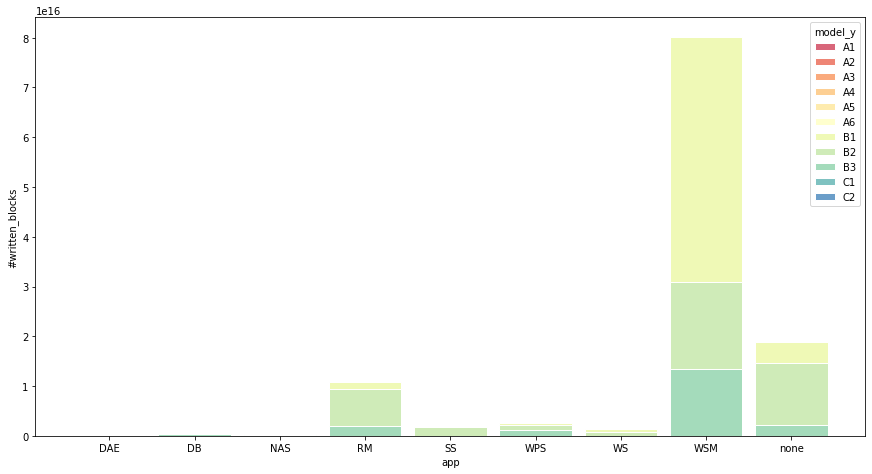

In [202]:
### To plot the number of write blocks for SDDs models per application

df_temp = df_temp_blocks_writtenreadwear_appModel.copy()

ax = sns.histplot(
    df_temp,
    x='app',
    # Use the value variable here to turn histogram counts into weighted
    # values.
    weights='n_b_written',
    hue='model_y',
    multiple='stack',
    palette='Spectral',
    #palette='icefire',
    #palette='husl',
    # Add white borders to the bars.
    edgecolor='white',
    # Shrink the bars a bit so they don't touch.
    shrink=0.85,
    hue_order = ['A1','A2','A3','A4','A5','A6','B1','B2','B3','C1','C2'],
    #stat="density", common_norm=True
)
#ax.axhline(df_general_AFRMTTF.loc[df_general_AFRMTTF['FailedSSDsSet'] == 'FailedSSDs', 'AFR_General'].values[0]*100)
ax.figure.set_figwidth(14.87) # increasing the figure width
ax.figure.set_figheight(7.7)
#ax.set_title('Tips by Day and Gender')
# Remove 'Count' ylabel.
ax.set_ylabel("#written_blocks")

/usr/local/lib/python3.8/dist-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


Text(0, 0.5, 'Density')

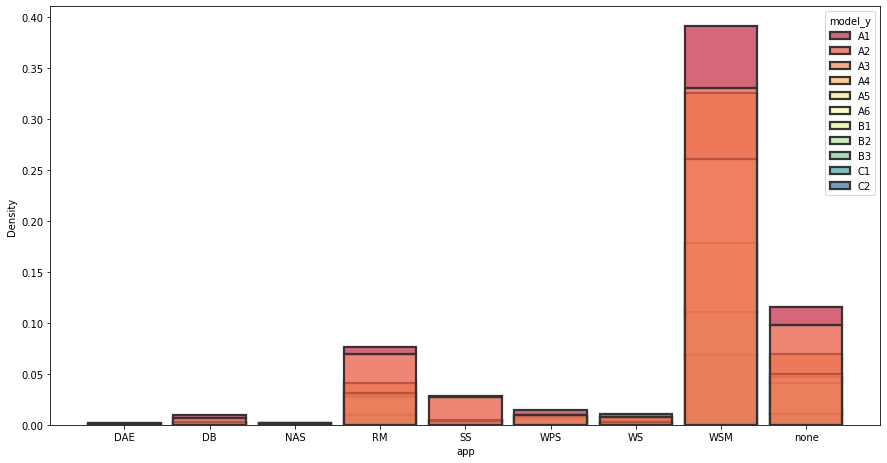

In [203]:
### To plot the number of write blocks for SDDs models per application - normalized

df_temp = df_temp_blocks_writtenreadwear_appModel.copy()

ax = sns.histplot(
    df_temp,
    x='app',
    # Use the value variable here to turn histogram counts into weighted
    # values.
    weights='n_b_written',
    hue='model_y',
    multiple='stack',
    palette='Spectral',
    #palette='icefire',
    #palette='husl',
    # Add white borders to the bars.
    #edgecolor='white',
    linewidth=2.2,
    edgecolor=".2",
    # Shrink the bars a bit so they don't touch.
    shrink=0.85,
    hue_order = ['A1','A2','A3','A4','A5','A6','B1','B2','B3','C1','C2'],
    stat="density", common_norm=True
)
#ax.axhline(df_general_AFRMTTF.loc[df_general_AFRMTTF['FailedSSDsSet'] == 'FailedSSDs', 'AFR_General'].values[0]*100)
ax.figure.set_figwidth(14.87) # increasing the figure width
ax.figure.set_figheight(7.7)
#ax.set_title('Tips by Day and Gender')
# Remove 'Count' ylabel.
ax.set_ylabel("Density")

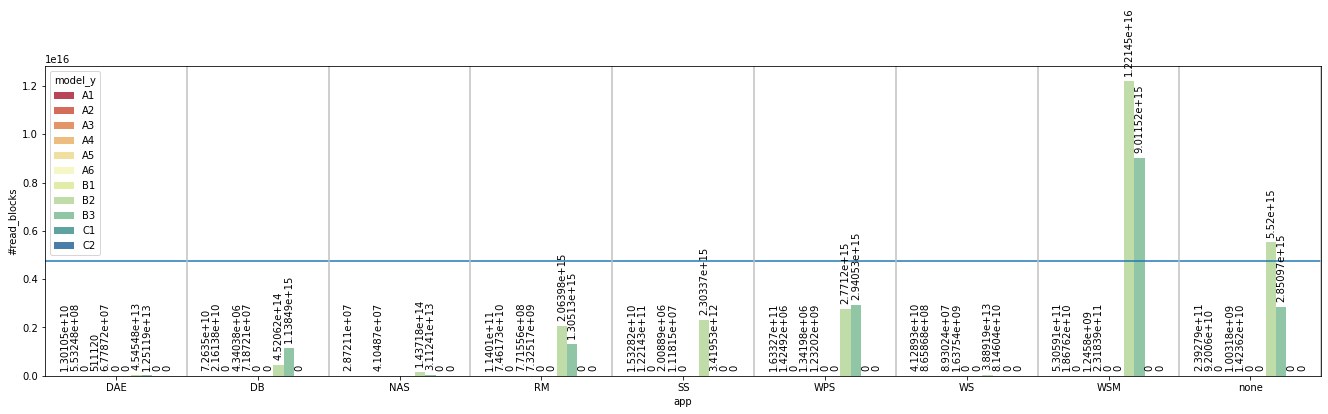

In [334]:
### To plot the number of read blocks for each application considering SSD models

df_temp = df_temp_blocks_writtenreadwear_appModel.copy()
df_temp

graph = sns.barplot(x = "app", y = 'n_b_read', palette = 'Spectral', hue = 'model_y', data = df_temp, hue_order = ['A1','A2','A3','A4','A5','A6','B1','B2','B3','C1','C2'])
for container in graph.containers:
    graph.bar_label(container, label_type='edge', rotation='vertical', padding=5)

graph.axhline((df_temp_blocks_writtenreadwear_app['n_b_read'].mean()))
graph.set_ylabel("#read_blocks")
graph.figure.set_figwidth(22.87) # increasing the figure width
graph.figure.set_figheight(5.7)
[graph.axvline(x+.5,color='silver') for x in graph.get_xticks()]
#sns.despine()
plt.show()

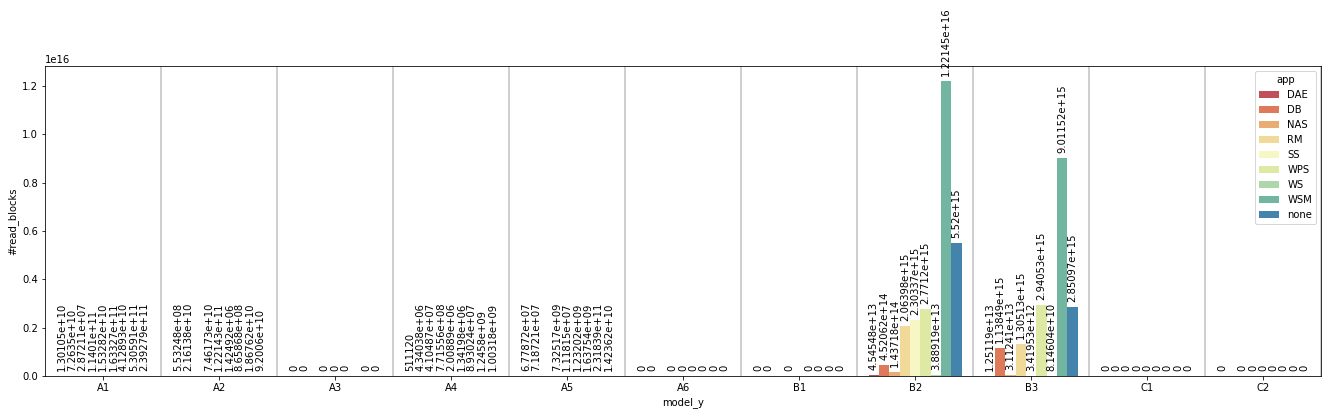

In [358]:
### To plot the number of read blocks per SSD models for each application

df_temp = df_temp_blocks_writtenreadwear_appModel.copy()
df_temp

graph = sns.barplot(x = "model_y", y = 'n_b_read', palette = 'Spectral', hue = 'app', data = df_temp, order = ['A1','A2','A3','A4','A5','A6','B1','B2','B3','C1','C2'])
for container in graph.containers:
    graph.bar_label(container, label_type='edge', rotation='vertical', padding=5)

#graph.axhline((df_temp_blocks_writtenreadwear_app['n_b_read'].mean()))
graph.set_ylabel("#read_blocks")
graph.figure.set_figwidth(22.87) # increasing the figure width
graph.figure.set_figheight(5.7)
[graph.axvline(x+.5,color='silver') for x in graph.get_xticks()]
#sns.despine()
plt.show()

Text(0, 0.5, '#read_blocks')

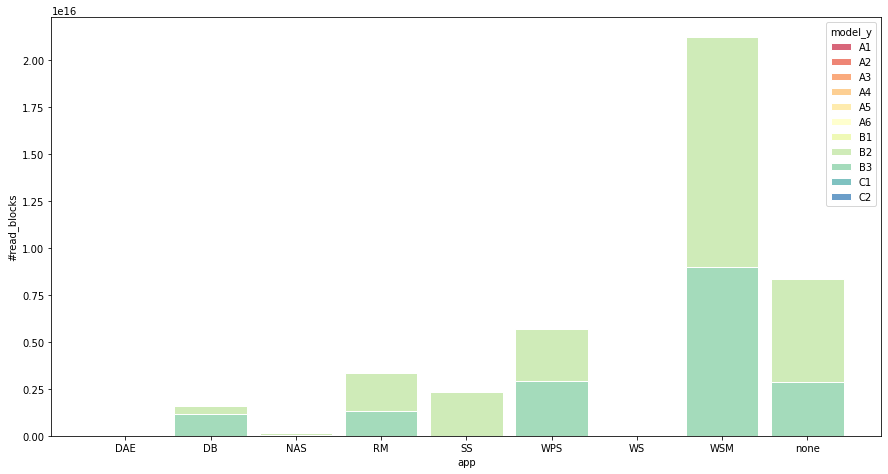

In [144]:
### To plot the number of read blocks for SDDs models per application

df_temp = df_temp_blocks_writtenreadwear_appModel.copy()

ax = sns.histplot(
    df_temp,
    x='app',
    # Use the value variable here to turn histogram counts into weighted
    # values.
    weights='n_b_read',
    hue='model_y',
    multiple='stack',
    palette='Spectral',
    #palette='icefire',
    #palette='husl',
    # Add white borders to the bars.
    edgecolor='white',
    # Shrink the bars a bit so they don't touch.
    shrink=0.85,
    hue_order = ['A1','A2','A3','A4','A5','A6','B1','B2','B3','C1','C2'],
    #stat="density", common_norm=True
)
#ax.axhline(df_general_AFRMTTF.loc[df_general_AFRMTTF['FailedSSDsSet'] == 'FailedSSDs', 'AFR_General'].values[0]*100)
ax.figure.set_figwidth(14.87) # increasing the figure width
ax.figure.set_figheight(7.7)
#ax.set_title('Tips by Day and Gender')
# Remove 'Count' ylabel.
ax.set_ylabel("#read_blocks")

/usr/local/lib/python3.8/dist-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


Text(0, 0.5, 'Density')

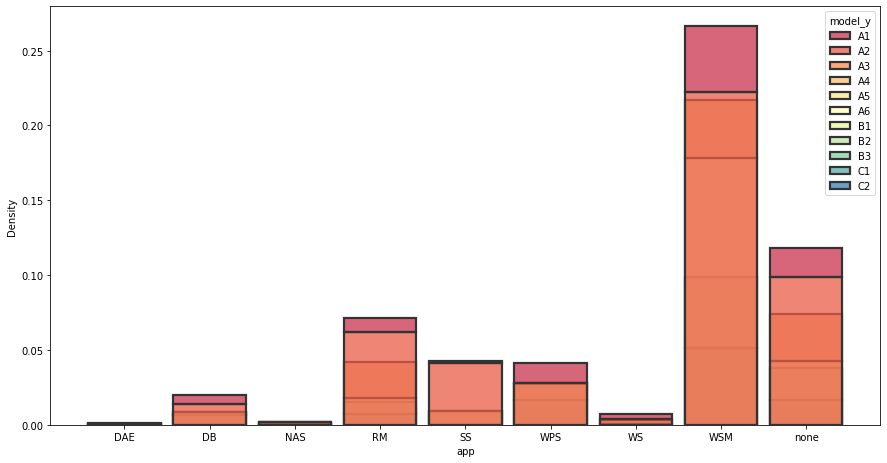

In [204]:
### To plot the number of read blocks for SDDs models per application - normalized

df_temp = df_temp_blocks_writtenreadwear_appModel.copy()

ax = sns.histplot(
    df_temp,
    x='app',
    # Use the value variable here to turn histogram counts into weighted
    # values.
    weights='n_b_read',
    hue='model_y',
    multiple='stack',
    palette='Spectral',
    #palette='icefire',
    #palette='husl',
    # Add white borders to the bars.
    #edgecolor='white',
    linewidth=2.2,
    edgecolor=".2",
    # Shrink the bars a bit so they don't touch.
    shrink=0.85,
    hue_order = ['A1','A2','A3','A4','A5','A6','B1','B2','B3','C1','C2'],
    stat="density", common_norm=True
)
#ax.axhline(df_general_AFRMTTF.loc[df_general_AFRMTTF['FailedSSDsSet'] == 'FailedSSDs', 'AFR_General'].values[0]*100)
ax.figure.set_figwidth(14.87) # increasing the figure width
ax.figure.set_figheight(7.7)
#ax.set_title('Tips by Day and Gender')
# Remove 'Count' ylabel.
ax.set_ylabel("Density")

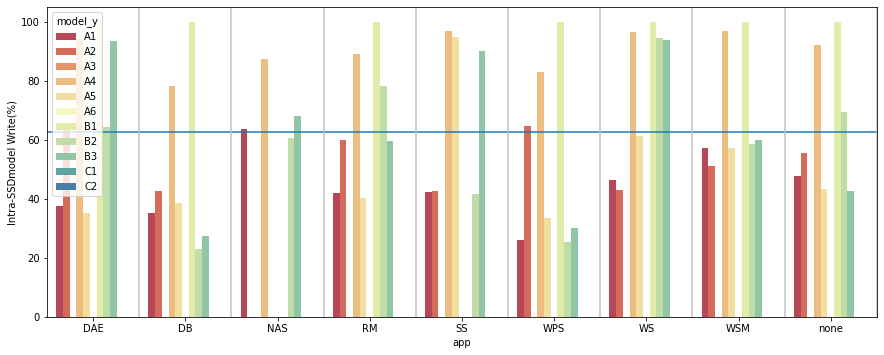

In [306]:
### To plot the percentage of write intra SSD model 

df_temp = df_temp_blocks_writtenreadwear_appModel.copy()

graph = sns.barplot(x = "app", y = '%write', palette = 'Spectral', hue = 'model_y', data = df_temp, hue_order = ['A1','A2','A3','A4','A5','A6','B1','B2','B3','C1','C2'])
#for container in graph.containers:
#    graph.bar_label(container, label_type='edge')

graph.axhline((df_temp_blocks_writtenreadwear_app['%write'].mean()))
graph.set_ylabel("Intra-SSDmodel Write(%)")
graph.figure.set_figwidth(14.87) # increasing the figure width
graph.figure.set_figheight(5.7)
[graph.axvline(x+.5,color='silver') for x in graph.get_xticks()]
#sns.despine()
plt.show()

Text(0, 0.5, 'Intra-SSDmodel Write(%)')

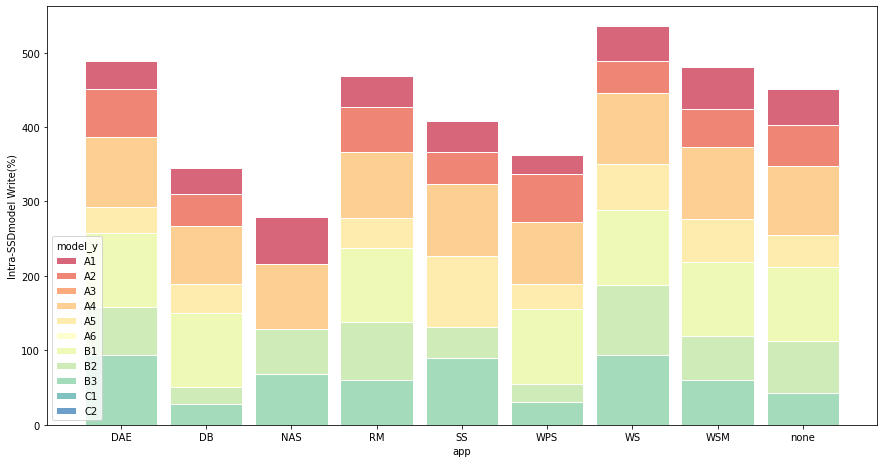

In [137]:
### To plot the percentage of write intra SSD model 

df_temp = df_temp_blocks_writtenreadwear_appModel.copy()

ax = sns.histplot(
    df_temp,
    x='app',
    # Use the value variable here to turn histogram counts into weighted
    # values.
    weights='%write',
    hue='model_y',
    multiple='stack',
    palette='Spectral',
    #palette='icefire',
    #palette='husl',
    # Add white borders to the bars.
    edgecolor='white',
    # Shrink the bars a bit so they don't touch.
    shrink=0.85,
    hue_order = ['A1','A2','A3','A4','A5','A6','B1','B2','B3','C1','C2'],
    #stat="density", common_norm=True
)
#ax.axhline(df_general_AFRMTTF.loc[df_general_AFRMTTF['FailedSSDsSet'] == 'FailedSSDs', 'AFR_General'].values[0]*100)
ax.figure.set_figwidth(14.87) # increasing the figure width
ax.figure.set_figheight(7.7)
#ax.set_title('Tips by Day and Gender')
# Remove 'Count' ylabel.
ax.set_ylabel("Intra-SSDmodel Write(%)")

/usr/local/lib/python3.8/dist-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


Text(0, 0.5, 'Density')

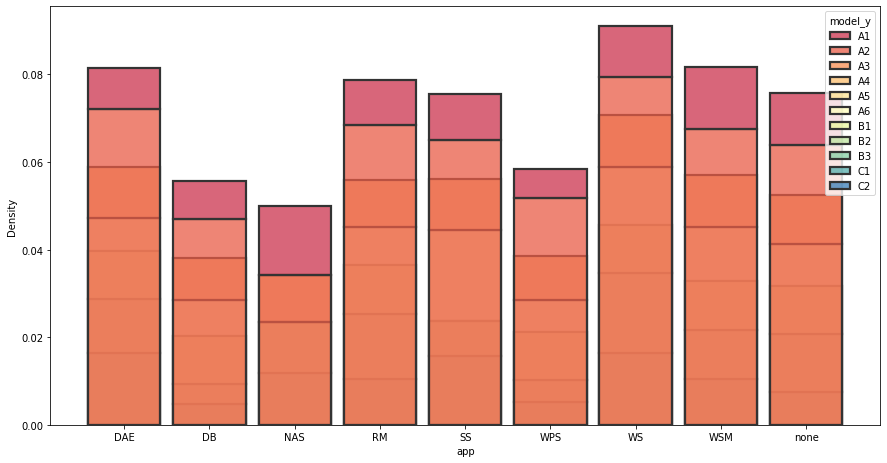

In [272]:
### To plot the percentage of write intra SSD model - normalized

df_temp = df_temp_blocks_writtenreadwear_appModel.copy()

ax = sns.histplot(
    df_temp,
    x='app',
    # Use the value variable here to turn histogram counts into weighted
    # values.
    weights='%write',
    hue='model_y',
    multiple='stack',
    palette='Spectral',
    #palette='icefire',
    #palette='husl',
    # Add white borders to the bars.
    linewidth=2.2,
    edgecolor=".2",
    # edgecolor='white',
    # Shrink the bars a bit so they don't touch.
    shrink=0.85,
    hue_order = ['A1','A2','A3','A4','A5','A6','B1','B2','B3','C1','C2'],
    stat="density", common_norm=True
)
#ax.axhline(df_general_AFRMTTF.loc[df_general_AFRMTTF['FailedSSDsSet'] == 'FailedSSDs', 'AFR_General'].values[0]*100)
ax.figure.set_figwidth(14.87) # increasing the figure width
ax.figure.set_figheight(7.7)
#ax.set_title('Tips by Day and Gender')
# Remove 'Count' ylabel.
ax.set_ylabel("Density")

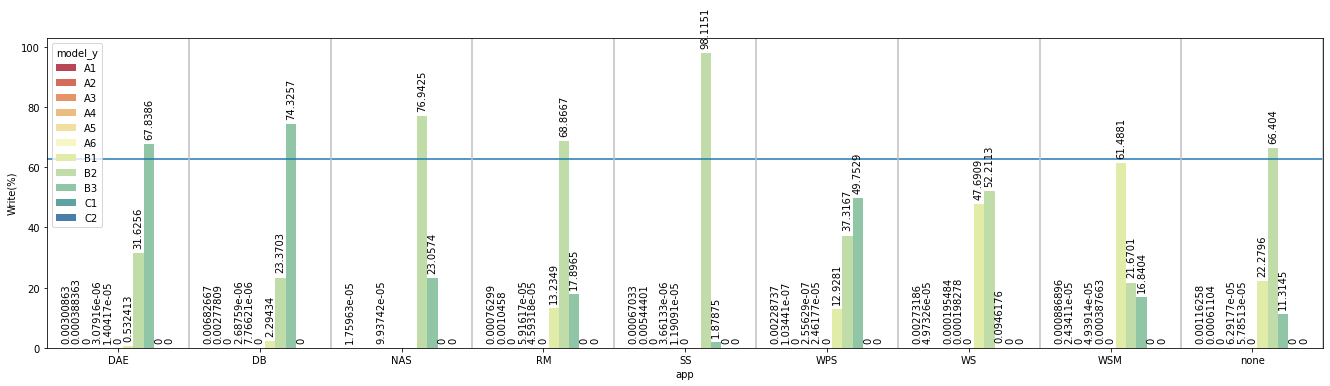

In [344]:
### To plot the percentage of write per SSD model intra application

df_temp = df_temp_blocks_writtenreadwear_appModel.copy()

graph = sns.barplot(x = "app", y = '%write_appModel', palette = 'Spectral', hue = 'model_y', data = df_temp, hue_order = ['A1','A2','A3','A4','A5','A6','B1','B2','B3','C1','C2'])
for container in graph.containers:
    graph.bar_label(container, label_type='edge', rotation='vertical', padding=5)

graph.axhline((df_temp_blocks_writtenreadwear_app['%write'].mean()))
graph.set_ylabel("Write(%)")
graph.figure.set_figwidth(22.87) # increasing the figure width
#graph.figure.set_figwidth(14.87) # increasing the figure width
graph.figure.set_figheight(5.7)
[graph.axvline(x+.5,color='silver') for x in graph.get_xticks()]
#sns.despine()
plt.show()

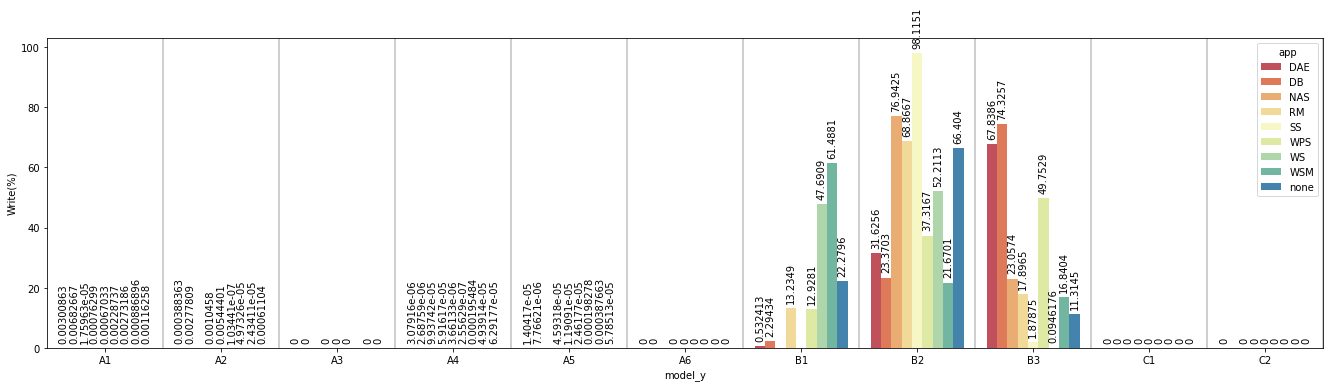

In [359]:
### To plot the percentage of write per SSD model for each application

df_temp = df_temp_blocks_writtenreadwear_appModel.copy()

graph = sns.barplot(x = "model_y", y = '%write_appModel', palette = 'Spectral', hue = 'app', data = df_temp, order = ['A1','A2','A3','A4','A5','A6','B1','B2','B3','C1','C2'])
for container in graph.containers:
    graph.bar_label(container, label_type='edge', rotation='vertical', padding=5)

#graph.axhline((df_temp_blocks_writtenreadwear_app['%write'].mean()))
graph.set_ylabel("Write(%)")
graph.figure.set_figwidth(22.87) # increasing the figure width
#graph.figure.set_figwidth(14.87) # increasing the figure width
graph.figure.set_figheight(5.7)
[graph.axvline(x+.5,color='silver') for x in graph.get_xticks()]
#sns.despine()
plt.show()

Text(0, 0.5, 'Intra-app Write(%)')

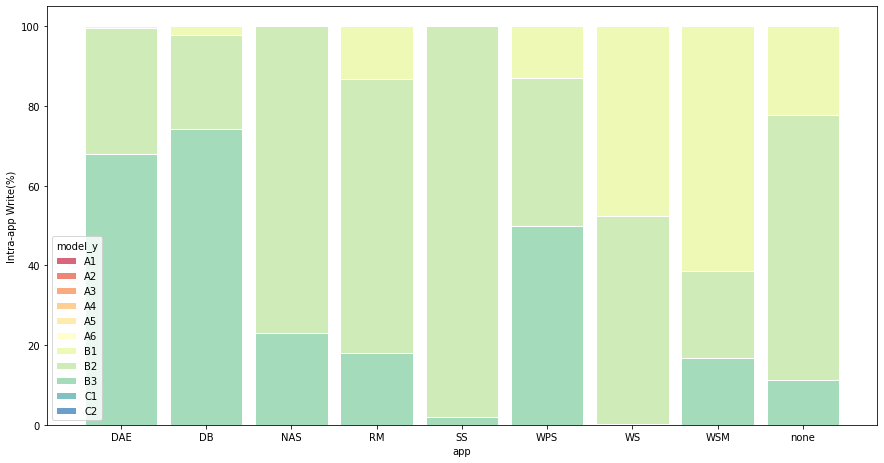

In [163]:
### To plot the percentage of write per SSD model intra application

df_temp = df_temp_blocks_writtenreadwear_appModel.copy()

ax = sns.histplot(
    df_temp,
    x='app',
    # Use the value variable here to turn histogram counts into weighted
    # values.
    weights='%write_appModel',
    hue='model_y',
    multiple='stack',
    palette='Spectral',
    #palette='icefire',
    #palette='husl',
    # Add white borders to the bars.
    edgecolor='white',
    # Shrink the bars a bit so they don't touch.
    shrink=0.85,
    hue_order = ['A1','A2','A3','A4','A5','A6','B1','B2','B3','C1','C2']
    #stat="density", common_norm=False
)
#ax.axhline(df_general_AFRMTTF.loc[df_general_AFRMTTF['FailedSSDsSet'] == 'FailedSSDs', 'AFR_General'].values[0]*100)
ax.figure.set_figwidth(14.87) # increasing the figure width
ax.figure.set_figheight(7.7)
#ax.set_title('Tips by Day and Gender')
# Remove 'Count' ylabel.
ax.set_ylabel("Intra-app Write(%)")

/usr/local/lib/python3.8/dist-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


Text(0, 0.5, 'Density')

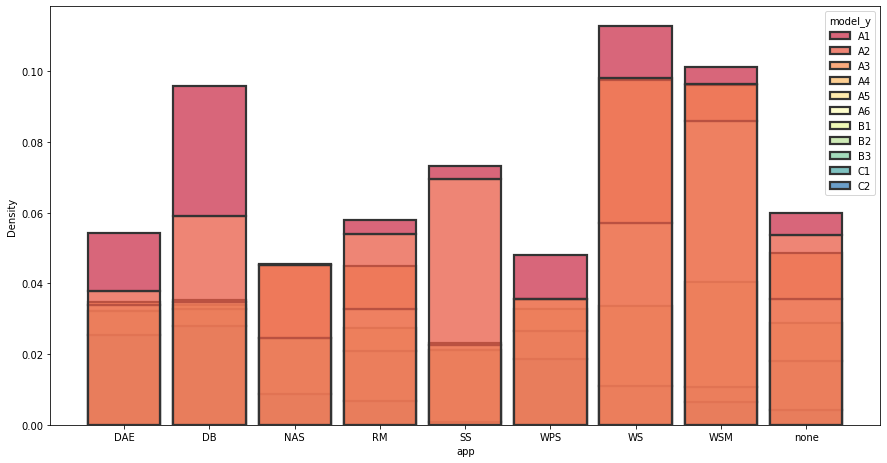

In [269]:
### To plot the percentage of write per SSD model intra application - normalized

df_temp = df_temp_blocks_writtenreadwear_appModel.copy()

ax = sns.histplot(
    df_temp,
    x='app',
    # Use the value variable here to turn histogram counts into weighted
    # values.
    weights='%write_appModel',
    hue='model_y',
    multiple='stack',
    palette='Spectral',
    #palette='icefire',
    #palette='husl',
    # Add white borders to the bars.
    #edgecolor='white',
    linewidth=2.2,
    edgecolor=".2",
    # Shrink the bars a bit so they don't touch.
    shrink=0.85,
    hue_order = ['A1','A2','A3','A4','A5','A6','B1','B2','B3','C1','C2'],
    stat="density", common_norm=True
)
#ax.axhline(df_general_AFRMTTF.loc[df_general_AFRMTTF['FailedSSDsSet'] == 'FailedSSDs', 'AFR_General'].values[0]*100)
ax.figure.set_figwidth(14.87) # increasing the figure width
ax.figure.set_figheight(7.7)
#ax.set_title('Tips by Day and Gender')
# Remove 'Count' ylabel.
ax.set_ylabel("Density")

### Plotting the AFRs and MTTFs per app - considering # ssds per app and # all ssds in this experiment

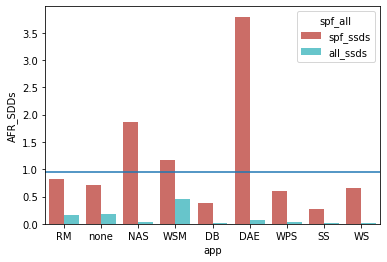

In [ ]:
#Creating a data frame to rearrange both AFRs and MTTF columns - creating the categorie/column spf_all: spf (specific) tl (total)
df_plotAFRMTTFSPF = df_idAppsSSDs.loc[:,['app','AFR_SDDs', 'mttf_SDDs']]
df_plotAFRMTTFTL = df_idAppsSSDs.loc[:,['app','AFR_SDDs_total','mttf_SDDs_total']]

df_plotAFRMTTFSPF = df_plotAFRMTTFSPF.assign(spf_all='spf_ssds')
df_plotAFRMTTFTL = df_plotAFRMTTFTL.assign(spf_all='all_ssds')
df_plotAFRMTTFTL.rename(columns = {'AFR_SDDs_total':'AFR_SDDs', 'mttf_SDDs_total':'mttf_SDDs'}, inplace=True)

df_plotAFRMTTFSPFTL = pd.concat([df_plotAFRMTTFSPF, df_plotAFRMTTFTL])
df_plotAFRMTTFSPFTL["AFR_SDDs"] = df_plotAFRMTTFSPFTL["AFR_SDDs"]*100

graph = sns.barplot(x = "app", y = 'AFR_SDDs', palette = 'hls', hue = 'spf_all', data = df_plotAFRMTTFSPFTL)
graph.axhline(df_general_AFRMTTF.loc[df_general_AFRMTTF['FailedSSDsSet'] == 'FailedSSDs', 'AFR_General'].values[0]*100)
plt.show()

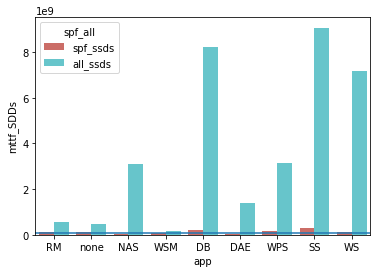

In [ ]:
graph = sns.barplot(x = "app", y = 'mttf_SDDs', palette = 'hls', hue = 'spf_all', data = df_plotAFRMTTFSPFTL)
graph.axhline(df_general_AFRMTTF.loc[df_general_AFRMTTF['FailedSSDsSet'] == 'FailedSSDs', 'MTTF_General'].values[0])
plt.show()

In [ ]:
## Saving sorted failure time per app into csv to be used for probability distribution fitting (All failed SDDs)

for i in id_apps:
    
    df_alibabasnapshot_toFitting = df_AlibabaSnapShot_FailuresAppsLocation.loc[df_AlibabaSnapShot_FailuresAppsLocation["app"] == i, "failure_time"]
    df_alibabasnapshot_toFitting.sort_values
    df_alibabasnapshot_toFitting.to_csv('Snapshot_FailureTimesApp' + i + '.csv', header=None, index=None)

df_alibabasnapshot_toFitting = df_AlibabaSnapShot_FailuresAppsLocation['failure_time']
df_alibabasnapshot_toFitting.to_csv('Snapshot_FailureTimesApp' + 'All' + '.csv', header=None, index=None)

In [ ]:
## Saving sorted failure time per app into csv to be used for probability distribution fitting (SSDs in common)

for i in id_apps:
    
    df_merge_toFitting_times = df_genMTTF_MergeDs_FailuresAppsLocation.loc[df_genMTTF_MergeDs_FailuresAppsLocation["app"] == i, "failure_time"]
    df_merge_toFitting_times.sort_values
    df_merge_toFitting_times.to_csv('MergeSSDs_FailureTimesApp' + i + '.csv', header=None, index=None)

In [ ]:
# Investigating Flash technology (using general mttf equation approach)

flashtech = pd.DataFrame({
'model_y':['A3', 'A2', 'B3' , 'B2', 'C1', 'C2'],  
'flash': ['MLC', 'MLC', 'MLC' , 'MLC', '3D-TLC', '3D-TLC']})

df_flashtech = pd.merge(df_result, flashtech, how='left', on=['model_y'])

df_flashtech = df_flashtech.groupby(['app','flash'])['failure_time'].mean()

df_flashtech = pd.DataFrame(df_flashtech)

df_flashtech.rename(columns = {'failure_time':'mttf_flash'}, inplace=True)

df_flashtech.to_csv('flashtech.csv')
#df_flashtech.head()


In [ ]:
# Investigating Capacity (using general mttf equation approach)

capacity = pd.DataFrame({
'model_y':['A3', 'A2', 'B3' , 'B2', 'C1', 'C2'],  
'capacity': ['480GB', '800GB', '1920GB' , '1920GB', '1920GB', '960GB']})

df_capacity = pd.merge(df_result, capacity, how='left', on=['model_y'])

df_capacity = df_capacity.groupby(['app','capacity'])['failure_time'].mean()

df_capacity = pd.DataFrame(df_capacity)

df_capacity.rename(columns = {'failure_time':'mttf_capacity'}, inplace=True)

df_capacity.to_csv('capacity.csv')
#df_capacity.head(50)

In [ ]:
##  Creating Graphs (cell still in progress)

fig = sns.catplot(x="app", y="failure_time", hue="model_x", data=df_failuresLocationDocumentsJson,
               row="node_id", col="rack_id", kind="bar", ci=90, palette="Blues_d", aspect=0.9, height=4.5
                  , legend_out = True, margin_titles = True)

fig.set_axis_labels("App", "MTTF")
fig.set_xticklabels(["DAE", "DB", "NAS", "RM", "SS", "WPS", "WS", "WSM", "none"])

plt.savefig('teste.pdf', dpi=1200)

## SMART ATTRIBUTES INVESTIGATION

In [ ]:
# Querying/Reading the SMARTAtt database (mongodb) filtering by a specific SSD (all cells below still in progress)

smartDocuments = SMARTAtt.objects(disk_id="19015").filter()

jSon_smartDocumentsJson = json.loads(smartDocuments.to_json())
df_smartDocumentsJson = pd.DataFrame.from_dict(jSon_smartDocumentsJson) 

df_smartDocumentsJson.head()

In [ ]:
smartDocumentsDB = SMARTAtt.objects(disk_id="95341").filter()

jSon_smartDocumentsDBJson = json.loads(smartDocumentsDB.to_json())
df_smartDocumentsDBJson = pd.DataFrame.from_dict(jSon_smartDocumentsDBJson) 

df_smartDocumentsDBJson.head()

In [ ]:
smartDocumentsNAS = SMARTAtt.objects(disk_id="18144").filter()

jSon_smartDocumentsNASJson = json.loads(smartDocumentsNAS.to_json())
df_smartDocumentsNASJson = pd.DataFrame.from_dict(jSon_smartDocumentsNASJson) 

df_smartDocumentsNASJson.head()

In [ ]:
smartDocumentsRM = SMARTAtt.objects(disk_id="99516").filter()

jSon_smartDocumentsRMJson = json.loads(smartDocumentsRM.to_json())
df_smartDocumentsRMJson = pd.DataFrame.from_dict(jSon_smartDocumentsRMJson) 

df_smartDocumentsRMJson.head()

In [ ]:
smartDocumentsSS = SMARTAtt.objects(disk_id="199807").filter()

jSon_smartDocumentsSSJson = json.loads(smartDocumentsSS.to_json())
df_smartDocumentsSSJson = pd.DataFrame.from_dict(jSon_smartDocumentsSSJson) 

df_smartDocumentsSSJson.head()

In [ ]:
smartDocumentsWPS = SMARTAtt.objects(disk_id="30010").filter()

jSon_smartDocumentsWPSJson = json.loads(smartDocumentsWPS.to_json())
df_smartDocumentsWPSJson = pd.DataFrame.from_dict(jSon_smartDocumentsWPSJson) 

df_smartDocumentsWPSJson.head()

In [ ]:
smartDocumentsWS = SMARTAtt.objects(disk_id="17304").filter()

jSon_smartDocumentsWSJson = json.loads(smartDocumentsWS.to_json())
df_smartDocumentsWSJson = pd.DataFrame.from_dict(jSon_smartDocumentsWSJson) 

df_smartDocumentsWSJson.head()

In [ ]:
smartDocumentsWSM = SMARTAtt.objects(disk_id="29755").filter()

jSon_smartDocumentsWSMJson = json.loads(smartDocumentsWSM.to_json())
df_smartDocumentsWSMJson = pd.DataFrame.from_dict(jSon_smartDocumentsWSMJson) 

df_smartDocumentsWSMJson.head()

In [ ]:
smartDocumentsnone = SMARTAtt.objects(disk_id="12463").filter()

jSon_smartDocumentsnoneJson = json.loads(smartDocumentsnone.to_json())
df_smartDocumentsnoneJson = pd.DataFrame.from_dict(jSon_smartDocumentsnoneJson) 

df_smartDocumentsnoneJson.head()

In [ ]:
#Mergin all smart attributes dataframes
df_smartDocumentsTotal = pd.concat([df_smartDocumentsJson, df_smartDocumentsDBJson, df_smartDocumentsNASJson, df_smartDocumentsRMJson, df_smartDocumentsSSJson, df_smartDocumentsWPSJson, df_smartDocumentsWSJson, df_smartDocumentsWSMJson, df_smartDocumentsnoneJson])

In [ ]:
# Selecting the columns of interest
df_smartDocumentsTotalFiltered = df_smartDocumentsTotal.loc[:,['disk_id', 'timestamp' , 'r_sectors', 'u_errors','n_b_written','n_b_read']]

dicDateToString = json.dumps(list(df_smartDocumentsTotalFiltered['timestamp']))
dicStringToJson = json.loads(dicDateToString)
dicJsonToDf = pd.DataFrame.from_dict(dicStringToJson)
df_smartDocumentsTotalFiltered['timestamp'] = dicJsonToDf['$date']

#Subctracting by the initial time of the experiment and turning into hours
df_smartDocumentsTotalFiltered['timestamp'] = df_smartDocumentsTotalFiltered.timestamp.sub(1514764800000)
df_smartDocumentsTotalFiltered['timestamp'] = df_smartDocumentsTotalFiltered.timestamp.div(1000)
df_smartDocumentsTotalFiltered['timestamp'] = df_smartDocumentsTotalFiltered.timestamp.div(60)

# Relating to the correspodent app
appAtt = pd.DataFrame({
'disk_id':[19015, 95341, 18144 , 99516, 199807, 30010, 17304, 29755, 12463],  
'app': ['DAE', 'DB', 'NAS', 'RM', 'SS', 'WPS', 'WS', 'WSM', 'none']})

df_smartDocumentsTotalFiltered = pd.merge(df_smartDocumentsTotalFiltered, appAtt, how='left', on=['disk_id'])

df_smartDocumentsTotalFiltered.to_csv('smartattributesanalysisMinutesApp.csv')
#df_smartDocumentsTotalFiltered.tail(10)

In [ ]:
df_smartDocumentsTotalFiltered.head()

In [ ]:
df_failuresLocationDocumentsJson.to_csv('failuresLocation.csv', index = None, header=True)